# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import warnings
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
import optuna
import pickle
import joblib
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier, XGBRFRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import root_mean_squared_log_error, mean_squared_log_error, mean_squared_error, r2_score, accuracy_score

from custom_metrics import (
    lgb_lse_objective, lgb_lse_objective_with_inverse, lgb_rmsle, lgb_rmsle_with_inverse, 
    xgb_rmsle_evaluation, xgb_rmsle_evaluation_with_inverse, xgb_sle_objective, xgb_sle_objective_with_inverse,
    RmsleMetric, SleObjective # for catboost rmsle
)
import winsound
def alert():
    duration = 1000  # milliseconds
    freq = 440  # Hz
    winsound.Beep(freq, duration)

import logging
logging.basicConfig(level=logging.ERROR)
plt.rcParams['figure.figsize'] = [21, 9]
plt.rcParams['figure.dpi'] = 300

# 다크모드에 맞는 스타일 설정
plt.style.use('dark_background')

# 추가적인 커스터마이징 (옵션)
plt.rcParams.update({
    'axes.edgecolor': 'white',         # 축의 테두리 색상
    'axes.labelcolor': 'white',       # 축 라벨 색상
    'xtick.color': 'white',           # x축 눈금 색상
    'ytick.color': 'white',           # y축 눈금 색상
    'grid.color': 'gray',             # 그리드 라인 색상
    'grid.alpha': 0.3,                # 그리드 투명도
    'text.color': 'white',            # 텍스트 색상
    'figure.facecolor': '#121212',    # 전체 그림 배경색
    'axes.facecolor': '#121212',      # 축 배경색
    'legend.facecolor': '#1e1e1e',    # 범례 배경색
    'legend.edgecolor': 'white',      # 범례 테두리 색상
})
plt.rcParams['agg.path.chunksize'] = 10000
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

Original dataset: https://www.kaggle.com/datasets/schran/insurance-premium-prediction/data

# Load Data

In [2]:
# 캐글 노트북이면 True, 아니면 False
if 'KAGGLE_URL_BASE' in os.environ:
    train_data = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv', index_col=0)
    test_data = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv', index_col=0)
else:
    train_data = pd.read_csv('./kaggle/input/playground-series-s4e12/train.csv', index_col=0)
    test_data = pd.read_csv('./kaggle/input/playground-series-s4e12/test.csv', index_col=0)
    
# non_log_oof, non_log_test = joblib.load(
#     './kaggle/input/cat_non_loged_origin.pkl'
# )
# non_log_oof, non_log_test = joblib.load(
#     './kaggle/input/cat_non_loged_simpler_date.pkl'
# )
non_log_oof, non_log_test = joblib.load(
    './kaggle/input/cat_non_loged.pkl'
)
cat102_oof, _, cat102_test = joblib.load(
    './kaggle/input/cat_1_02.pkl'
)

In [3]:
train_data.columns = train_data.columns.str.lower().str.replace(' ', '_')
test_data.columns = test_data.columns.str.lower().str.replace(' ', '_')

# non log as feature
train_data['non_log'] = non_log_oof
test_data['non_log'] = non_log_test
train_data['cat_102'] = cat102_oof
test_data['cat_102'] = cat102_test.mean(1)

# 타겟 변수 및 피처 분리
target_column = 'premium_amount'
data = pd.concat([train_data, test_data]).drop(columns=target_column)
y = train_data[target_column].values
gmm_columns = []
del train_data, test_data

# Into Classifying problem using GMM

# raw y binning

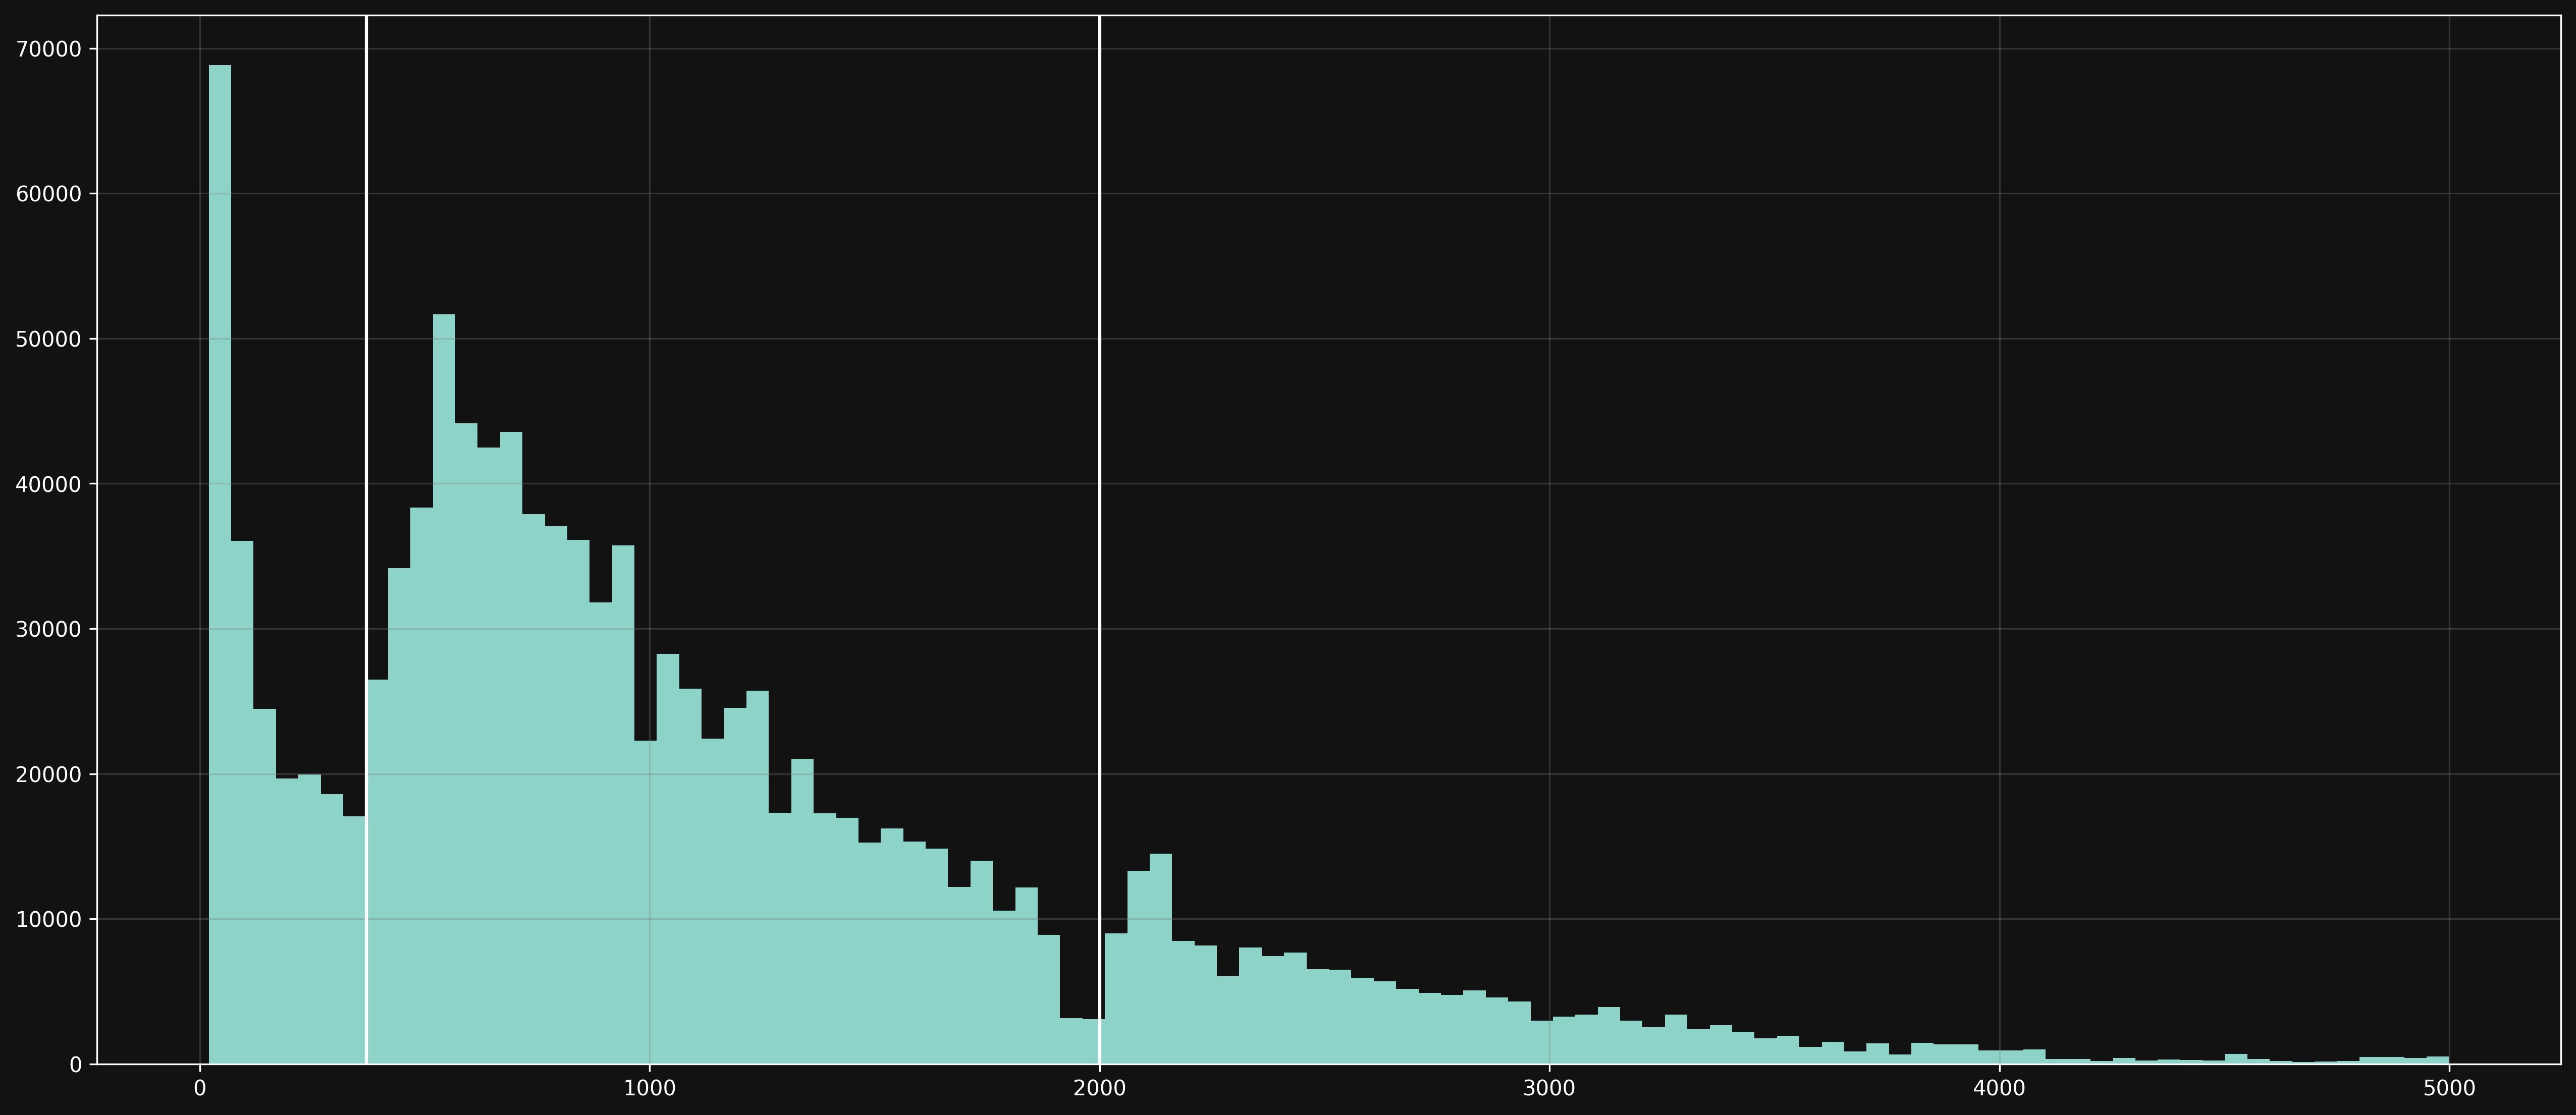

In [4]:
pd.Series(y).hist(bins=100)
plt.axvline(370)
plt.axvline(2000)

In [4]:
GMM_COMPONENTS = 2
data['gmm_class'] = -99
data['gmm_class'].iloc[:len(y)] = ((y <= 370) * 1 + ((y > 370) & (y <= 2000)) * 2 + (y > 2000) * 3)
gmm_columns = ['gmm_class']

# Data Preprocessing

In [5]:
train_columns = data.columns
train_columns=train_columns.append(
    pd.Index([
        # 'vehicle_age_health_score',
        # 'health_score_age_ratio',
        # 'age_vehicle_age_ratio',
        # 'annual_income_dependents_ratio',
        # # 'annual_income_health_score_dependents_ratio',
        # 'insurance_duration_previous_claims_ratio',
        # # 'exercise_health_smoking_ratio',
        # 'health_exercise_smoking_ratio',
        
        # 'smoking_exercise_health_score_category',
        # 'marital_dependents_occupation_category',
        # 'age_gender_marital_category',
        
        # 'claims_vs_duration',
        # # 'days_from_2019_crisis',
        # 'revenue_per_dependent',
        # 'ratio_of_doubts',
    ])
)
train_columns = train_columns.drop(['premium_amount']+gmm_columns, errors='ignore')

In [6]:

train_columns=train_columns.drop([
    # 'vehicle_age',
    # 'health_score',
    # 'annual_income',
    # 'smoking_status',
    # 'gender',
    # 'marital_status',
    # 'age',
])


In [7]:
# data['vehicle_age_health_score'] = data['vehicle_age'] * data['health_score']
# data['health_score_age_ratio'] = data['health_score'] / data['age']
# data['age_vehicle_age_ratio'] = data['age'] / (data['vehicle_age']+1)
# data['annual_income_dependents_ratio'] = np.log(data['annual_income'] / (data['number_of_dependents']+1))
# # data['annual_income_health_score_dependents_ratio'] = (data['annual_income'] * data['health_score']) / (data['number_of_dependents']+1)
# data['insurance_duration_previous_claims_ratio'] = ((data['insurance_duration']+1)/(data['previous_claims']+1))
# data['health_exercise_smoking_ratio'] = (data['health_score'] * data['exercise_frequency'].apply(lambda x: 1/7 if x=='Weekly' else 1/30 if x=='Monthly' else 1 if x=='Daily' else 1/100) / (2 + data['smoking_status'].apply(lambda x: 0 if x == 'No' else 1)))

# data['smoking_exercise_health_score_category'] = (data['smoking_status'].fillna('unknown') + '_' + data['exercise_frequency'].fillna('unknown') + '_' + pd.qcut(data['health_score'], q=4).astype(str).fillna('unknown'))
# data['marital_dependents_occupation_category'] = (data['marital_status'].fillna('unknown') + '_' + data['number_of_dependents'].astype(str).fillna('unknown') + '_' + data['occupation'].fillna('unknown'))
# data['age_gender_marital_category'] = (pd.qcut(data['age'], q=4).astype(str) + '_' + data['marital_status'].fillna('unknown') + '_' + data['marital_status'].fillna('unknown'))

# From catboost-insurance-1-02.ipynb
data['claims_vs_duration'] = data['previous_claims'] / data['insurance_duration']
# data['days_from_2019_crisis'] = (pd.to_datetime(data['policy_start_date']) - pd.Timestamp('2019-01-01')).dt.days
data['revenue_per_dependent'] = (data['annual_income'] / data['number_of_dependents'] + 1)
data['ratio_of_doubts'] = (data['previous_claims'] + 1) / data['annual_income'] # NEW
data.revenue_per_dependent.replace(np.inf, data.revenue_per_dependent.replace(np.inf, np.nan).max() * 1.1, inplace=True)
data.ratio_of_doubts.replace(np.inf, 5, inplace=True)

In [8]:
# policy_start_date 피처 전처리
data['policy_start_date'] = pd.to_datetime(data['policy_start_date'])
data['policy_start_year'] = data['policy_start_date'].dt.year.astype(str)
data['policy_start_month'] = data['policy_start_date'].dt.month.astype(str)

data['policy_start_date'] = (data['policy_start_date'] - pd.to_datetime('1970-01-01')).dt.days.astype(float)
train_columns = train_columns.append(pd.Index(['policy_start_date', 'policy_start_year', 'policy_start_month']))

In [9]:
# --- 2. 결측치 처리 ---

# number_of_dependents, insurance_duration, previous_claims is categorical
data['number_of_dependents'] = data['number_of_dependents'].apply(lambda x: str(x))
data['insurance_duration'] = data['insurance_duration'].apply(lambda x: str(x))
data['previous_claims'] = data['previous_claims'].apply(lambda x: str(x))


# age to binned, vehicle_age to binned
data['age'] = pd.qcut(data['age'], q=20, duplicates='drop')
data['vehicle_age'] = pd.qcut(data['vehicle_age'], q=20, duplicates='drop')


categorical_columns = data.select_dtypes(include=['object', 'category', 'int32']).columns
ordinal_categories = ['age', 'vehicle_age', 'number_of_dependents', 'insurance_duration', 'previous_claims']
categorical_columns = categorical_columns.drop(ordinal_categories)

# 범주형 변수의 결측치를 'unknown'으로 대체
for col in categorical_columns:
    data[col].fillna('unknown', inplace=True)


# 수치형 변수의 결측치를 최대값 + 10%로 대체
float_columns = data.select_dtypes(include=['float64']).columns.drop(['non_log', 'cat_102'], errors='ignore')
for col in float_columns:
    data[col].fillna(data[col].max() * 1.1, inplace=True)
    
int_columns = data.select_dtypes(include=['int64']).columns
for col in int_columns:
    data[col].fillna(data[col].max()+int(data[col].std()), inplace=True)
numerical_columns = float_columns.append(int_columns)
numerical_columns = numerical_columns.drop(gmm_columns, errors='ignore')

# --- 3. 범주형 변수 인코딩 및 수치형 스케일링 ---
# 범주형 변수 인코딩
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = data[col].fillna('unknown')
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
    
    
# 순서 범주형 변수 인코딩
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1)
data[ordinal_categories] = ordinal_encoder.fit_transform(data[ordinal_categories])

# 수치형 변수 스케일링
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
y_val_origin = y.copy()
y_scaler = StandardScaler()
y_scaler.fit(np.log1p(y).reshape(-1,1))
# y_scaler_torch = TorchStandardScaler()
# y_scaler_torch.fit(torch.tensor(torch.log1p(torch.tensor(y, dtype=torch.float32).to(device)).squeeze(-1)))
y = y_scaler.transform(np.log1p(y).reshape(-1,1)).reshape(-1)

try:
    display(data.non_log)
    # non log target scaling with y scaler
    data['non_log'] = y_scaler.transform(np.log1p(data['non_log']).values.reshape(-1,1)).reshape(-1)
    data['cat_102'] = y_scaler.transform(data['cat_102'].values.reshape(-1,1)).reshape(-1)
    print('non_log found')
except:
    print('non_log not found')

data[target_column] = np.pad(y, (0, data.shape[0]-len(y)), 'constant', constant_values=np.nan)

# X = data[:len(y)][train_columns].drop(columns=target_column, errors='ignore').copy()
y_val_origin = data[target_column].values[:len(y)]

X_test = data[data[target_column].isna()].drop(columns=[target_column]+gmm_columns, errors='ignore')[train_columns].copy()
_X = data[:len(y)].drop(columns=[target_column]+ gmm_columns, errors='ignore').copy()

id
0          1157.349226
1           986.698346
2          1107.179117
3          1265.484763
4          1291.093833
              ...     
1999995    1175.364633
1999996    1504.950450
1999997    1148.491311
1999998    1412.467793
1999999    1085.890563
Name: non_log, Length: 2000000, dtype: float64

non_log found


In [10]:
for col in data.columns:
    if data[col].nunique() < 20 and data[col].dtype not in ['object', 'int32', 'int64', 'int']:
        if col not in ['vehicle_age']:
            print(col)
            data[col] = data[col].astype(int)
            print(data[col].unique())

number_of_dependents
[1 3 2 0 4 5]
previous_claims
[ 2  1  0 10  3  4  5  6  7  8  9]
insurance_duration
[4 1 2 0 3 5 7 8 6 9]


# Functions

In [11]:
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error

def inverse_y(y):
    if isinstance(y, pd.Series):
        return np.expm1(y_scaler.inverse_transform(y.values.reshape(-1,1)).reshape(-1))
    else:
        return np.expm1(y_scaler.inverse_transform(y.reshape(-1,1)).reshape(-1))

def evaluate_model(model, X_val, y_val):
    """
    Evaluate model with r2, mse, rmsle
    
    Args:
    model : model to evaluate
    X_val : validation data
    y_val : validation target
    
    Returns:
    r2 : r2 score
    mse : mean squared error
    rmsle : root mean squared log error
    """
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    
    
    y_pred = inverse_y(y_pred)
    y_val = inverse_y(y_val)
    
    rmsle = mean_squared_log_error(y_val, y_pred) ** (1/2)
    return r2, mse, rmsle

def evaluate_model_no_inverse(model, X_val, y_val):
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    # y_pred = inverse_y(y_pred)
    # y_val = inverse_y(y_val)
    rmsle = mean_squared_log_error(y_val, y_pred) ** (1/2)
    return r2, mse, rmsle

# Regress on each y bins

## Devide Dataset

### For y origin < 375

In [12]:
reg_cols = [col for col in data.columns if '_reg' in col]
X = data.iloc[:len(y)][inverse_y(data[target_column].iloc[:len(y)]) < 375].drop(columns=[target_column]+gmm_columns+reg_cols).copy()
_y = data[target_column].iloc[:len(y)][inverse_y(data[target_column].iloc[:len(y)]) < 375].values
y_val_origin = data[target_column].iloc[:len(y)][inverse_y(data[target_column].iloc[:len(y)]) < 375].values
X_test = data.iloc[len(y):].drop(columns=[target_column]+gmm_columns+reg_cols).copy()
X_train, X_val, y_train, y_val = train_test_split(X.values, _y, test_size=0.2, random_state=42)

In [13]:
display(X)
_y.shape

,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,policy_type,previous_claims,vehicle_age,credit_score,insurance_duration,policy_start_date,customer_feedback,smoking_status,exercise_frequency,property_type,non_log,cat_102,claims_vs_duration,revenue_per_dependent,ratio_of_doubts,policy_start_year,policy_start_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,
7,12.0,0,2.219515,0,2,1,0,-1.471306,1,1,1,9.0,-1.313681,4,0.338253,0,0,2,1,0.304694,-0.078896,-0.683170,0.002462,-0.702309,3,10
8,1.0,1,-0.892086,0,3,0,3,-0.671863,2,2,1,8.0,0.297434,7,-0.816060,0,0,1,1,0.016531,-0.647393,-0.700118,-0.856898,-0.701429,1,3
9,10.0,1,0.365258,1,2,2,0,-0.499803,2,1,1,7.0,0.016752,2,-1.073000,2,0,0,1,-0.149921,-1.295955,-0.653041,-0.507299,-0.702292,1,10
14,9.0,0,-0.342578,0,5,1,1,0.068957,1,0,2,13.0,-0.752317,0,-0.350116,1,0,2,1,0.464096,0.194149,-0.276421,1.609353,-0.702224,2,10
16,17.0,0,-0.234258,0,2,3,2,-0.420535,2,0,0,14.0,1.694669,2,1.532833,0,1,3,1,0.410050,0.084828,-0.728365,-0.672114,-0.702294,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199959,12.0,1,-0.906119,1,3,3,0,-0.811804,1,1,0,9.0,1.694669,3,1.638293,1,1,1,1,0.496422,-0.103981,-0.728365,-0.859469,-0.701658,5,8
1199963,1.0,0,-0.893351,2,4,0,0,0.681369,2,2,0,0.0,0.173934,1,-0.666498,1,0,3,2,0.369654,-0.090358,-0.728365,-0.859040,-0.701861,2,5
1199981,0.0,0,-0.347834,2,1,1,1,-0.849998,1,0,10,12.0,-1.072295,7,0.859803,0,0,3,2,0.370224,0.148398,1.508755,-0.541903,1.424724,4,7


(206603,)

In [14]:
rf = XGBRFRegressor(
    n_estimators=300, 
    # max_depth=10,
    random_state=42, 
    n_jobs=-1, 
    # tree_method='gpu_hist'
)
rf.fit(X_train, y_train)
evaluate_model(rf, X_val, y_val)

(0.2038003992707842, 0.5294853770105106, 0.7973846765001811)

In [ ]:
lgb_leaves = 31
lgb_max_depth = 6
lgb_n_estimators = 300

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models= []
# out of fold predictions on trained data
oof_preds_under_375 = np.zeros(X.shape[0])
# prediction on outside the trainable bins
outside_X = _X.iloc[:len(y)][~_X.index.isin(X.index)]
outside_preds_under_375 = np.zeros((outside_X.shape[0], 5))
# prediction on test data
test_pred_under_375 = np.zeros((data.iloc[len(y):].shape[0], 5))
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, _X_val = X.values[train_idx], X.values[val_idx]
    y_train, _y_val = _y[train_idx], _y[val_idx]
    model = XGBRFRegressor(
        n_estimators=300, 
        # max_depth=10,
        random_state=42, 
        n_jobs=-1, 
        # tree_method='gpu_hist'
    )
    model.fit(X_train, y_train)
    models.append(model)
    pred = model.predict(_X_val)
    oof_preds_under_375[val_idx] = pred
    outside_preds_under_375[:, i] = model.predict(outside_X)
    test_pred_under_375[:, i] = model.predict(X_test)
    print(evaluate_model(model, _X_val, _y_val))
del _X_val, _y_val

(0.20371411812045714, 0.529542755345501, 0.797427883359019)
(0.197097367123935, 0.5322985253310032, 0.799500118712914)
(0.2001441621344473, 0.53198511805967, 0.7992647197191393)
(0.20297292832214975, 0.5306176874375172, 0.7982368319658592)
(0.2008162228058099, 0.5284931402726862, 0.7966371943228626)


#### Fill original data properly

In [16]:
oof_preds_under_375.shape, outside_preds_under_375.shape, test_pred_under_375.shape

((206603,), (993397, 5), (800000, 5))

In [17]:
data['under_375_reg'] = pd.concat([
    pd.Series(oof_preds_under_375, index = X.index), 
    pd.Series(outside_preds_under_375.mean(axis=1), index = outside_X.index), 
    pd.Series(test_pred_under_375.mean(axis=1), index = X_test.index)
]).sort_index()
del oof_preds_under_375, outside_preds_under_375, test_pred_under_375

### For 375 <= y origin < 2000

In [18]:
reg_cols = [col for col in data.columns if '_reg' in col]

X = data.iloc[:len(y)][(inverse_y(data[target_column].iloc[:len(y)]) < 2000) 
    & (inverse_y(data[target_column].iloc[:len(y)]) >= 375)].drop(columns=[target_column]+gmm_columns+reg_cols).copy()
_y = data[target_column].iloc[:len(y)][(inverse_y(data[target_column].iloc[:len(y)]) < 2000) 
    & (inverse_y(data[target_column].iloc[:len(y)]) >= 375)].values
y_val_origin = data[target_column].iloc[:len(y)][(inverse_y(data[target_column].iloc[:len(y)]) < 2000) 
    & (inverse_y(data[target_column].iloc[:len(y)]) >= 375)].values
X_test = data.iloc[len(y):].drop(columns=[target_column]+gmm_columns+reg_cols).copy()
X_train, X_val, y_train, y_val = train_test_split(X.values, _y, test_size=0.2, random_state=42)

In [19]:
display(X)
_y.shape, _y.mean()

,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,policy_type,previous_claims,vehicle_age,credit_score,insurance_duration,policy_start_date,customer_feedback,smoking_status,exercise_frequency,property_type,non_log,cat_102,claims_vs_duration,revenue_per_dependent,ratio_of_doubts,policy_start_year,policy_start_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,
1,8.0,0,-0.149665,0,3,2,3,-0.823814,0,1,1,10.0,0.347957,1,0.928832,0,1,1,2,0.275125,0.054876,-0.615379,-0.720829,-0.702272,4,8
2,2.0,1,-0.300306,0,3,1,1,1.264546,1,2,1,12.0,1.694669,2,1.139753,1,1,3,2,0.380156,0.157791,-0.653041,-0.748438,-0.702261,4,11
3,1.0,1,2.581937,1,2,0,3,-1.129828,0,0,1,0.0,-1.487704,0,1.630624,2,1,0,0,0.502007,0.138329,-0.502393,0.102097,-0.702310,5,8
6,9.0,1,0.064992,1,0,3,3,2.433735,0,0,2,6.0,0.982298,5,-1.385546,2,0,3,2,0.417649,0.163239,-0.653041,1.384431,-0.702264,1,4
10,16.0,0,-0.735371,1,1,0,2,2.433735,0,2,1,6.0,-1.128431,7,-0.530358,0,0,1,1,0.294884,0.155359,-0.700118,-0.754982,-0.702129,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199993,8.0,1,-0.895210,1,1,1,3,-0.626752,1,1,0,10.0,-0.915113,1,0.342088,1,0,2,2,0.399069,0.113546,-0.728365,-0.842866,-0.701840,3,10
1199994,6.0,1,-0.353511,2,4,2,1,-0.875765,0,0,10,10.0,-0.471635,8,0.923080,1,0,1,0,0.450326,0.120648,1.508755,-0.784835,1.424724,4,8
1199995,7.0,0,-0.257811,1,0,2,2,-0.942532,2,2,10,3.0,-1.459636,2,0.852133,2,0,0,0,0.463254,0.329536,1.508755,1.384431,1.424724,4,7


((804351,), 0.1781193699683284)

In [20]:
X_train.shape, X_val.shape

((643480, 26), (160871, 26))

In [21]:
rf = XGBRFRegressor(
    # n_estimators=500, 
    max_depth=5,
    random_state=42, 
    n_jobs=-1, 
    # tree_method='gpu_hist'
)
rf.fit(X_train, y_train)
evaluate_model(rf, X_val, y_val)

(0.05973546750772207, 0.14379845573252897, 0.4155449533266355)

In [20]:
rf = XGBRFRegressor(
    n_estimators=500, 
    max_depth=5,
    random_state=42, 
    n_jobs=-1, 
    # tree_method='gpu_hist'
)
rf.fit(X_train, y_train)
evaluate_model(rf, X_val, y_val)

(0.03167007940135558, 0.14809060898277693, 0.4217010288146948)

In [ ]:
# TODO: LightGBM Regressor

lgbm = LGBMRegressor(
    # **{
    #     'n_estimators': 904,
    #     'learning_rate': 0.22397849703318146,
    #     'max_depth': 6,
    #     'reg_lambda': 1.0772060124044087,
    #     'subsample': 0.7276099887947944,
    #     'subsample_freq': 1,
    #     'min_child_samples': 12
    # },
    
    num_leaves=lgb_leaves,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=lgb_n_estimators,
    max_depth=lgb_max_depth,
    learning_rate=0.1,
    
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    gpu_id=0,
    device_type='gpu',
)

lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='mse')
evaluate_model(lgbm, X_val, y_val)

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models= []
# out of fold predictions on trained data
oof_preds_under_2000 = np.zeros(X.shape[0])
# prediction on outside the trainable bins
outside_X = _X.iloc[:len(y)][~_X.index.isin(X.index)]
outside_preds_under_2000 = np.zeros((outside_X.shape[0], 5))
# prediction on test data
test_pred_under_2000 = np.zeros((data.iloc[len(y):].shape[0], 5))
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, _X_val = X.values[train_idx], X.values[val_idx]
    y_train, _y_val = _y[train_idx], _y[val_idx]
    model = XGBRFRegressor(
        # n_estimators=500, 
        max_depth=5,
        random_state=42, 
        n_jobs=-1, 
        # tree_method='gpu_hist'
    )
    model.fit(X_train, y_train)
    models.append(model)
    pred = model.predict(_X_val)
    oof_preds_under_2000[val_idx] = pred
    outside_preds_under_2000[:, i] = model.predict(outside_X)
    test_pred_under_2000[:, i] = model.predict(X_test)
    print(evaluate_model(model, _X_val, _y_val))
del _X_val, _y_val

(0.059735705742145706, 0.14379841929837553, 0.4155449012435747)
(0.056309045550727355, 0.1440919525992561, 0.4159688073106858)
(0.058350524155381334, 0.14393260882157927, 0.4157387451535027)
(0.058776385292063305, 0.1436389189460473, 0.41531437776989855)
(0.057725578295620306, 0.14379346825043562, 0.4155377471535128)


#### Fill original data properly

In [24]:
oof_preds_under_2000.shape, outside_preds_under_2000.shape, test_pred_under_2000.shape

((804351,), (395649, 5), (800000, 5))

In [25]:
data['under_2000_reg'] = pd.concat([
    pd.Series(oof_preds_under_2000, index = X.index), 
    pd.Series(outside_preds_under_2000.mean(axis=1), index = outside_X.index), 
    pd.Series(test_pred_under_2000.mean(axis=1), index = X_test.index)
]).sort_index()
del oof_preds_under_2000, outside_preds_under_2000, test_pred_under_2000

### For y origin >= 2000

In [26]:
reg_cols = [col for col in data.columns if '_reg' in col]
X = data.iloc[:len(y)][inverse_y(data[target_column].iloc[:len(y)]) >= 2000].drop(columns=[target_column]+gmm_columns+reg_cols).copy()
_y = data[target_column].iloc[:len(y)][inverse_y(data[target_column].iloc[:len(y)]) >= 2000].values
y_val_origin = data[target_column].iloc[:len(y)][inverse_y(data[target_column].iloc[:len(y)]) >= 2000].values
X_test = data.iloc[len(y):].drop(columns=[target_column]+gmm_columns+reg_cols).copy()
X_train, X_val, y_train, y_val = train_test_split(X.values, _y, test_size=0.2, random_state=42)

In [27]:
display(X)
_y.shape

,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,policy_type,previous_claims,vehicle_age,credit_score,insurance_duration,policy_start_date,customer_feedback,smoking_status,exercise_frequency,property_type,non_log,cat_102,claims_vs_duration,revenue_per_dependent,ratio_of_doubts,policy_start_year,policy_start_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0,-0.685909,1,1,0,1,-0.359399,2,2,2,15.0,-1.459636,4,1.300820,2,0,3,2,0.420562,0.261167,-0.637976,-0.727786,-0.702090,4,3
4,1.0,1,0.048009,2,1,0,1,-0.506253,0,2,0,6.0,-0.190953,3,-0.141113,2,1,3,2,0.520275,0.223871,-0.728365,-0.324258,-0.702302,2,3
5,4.0,1,0.204501,1,1,0,3,0.331336,2,2,2,2.0,-0.101135,4,0.184856,0,0,3,2,0.378877,0.163446,-0.637976,-0.238214,-0.702271,3,7
21,10.0,0,-0.586911,0,2,2,3,-1.551778,2,0,10,4.0,0.937389,4,1.022788,1,1,3,0,0.363482,0.056540,1.508755,-0.769063,1.424724,4,9
23,6.0,0,-0.122789,0,1,0,3,-0.401100,0,2,0,8.0,0.931775,0,-1.454575,0,1,1,1,-0.017125,-0.184667,-0.728365,-0.418167,-0.702298,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199975,3.0,1,-0.545705,0,2,0,3,-0.331915,1,0,0,9.0,-0.460408,0,0.016119,1,0,0,0,0.430803,0.128201,-0.728365,-0.757735,-0.702272,3,4
1199978,5.0,1,-0.762197,0,2,0,0,0.911764,2,0,0,12.0,-0.741090,7,0.209783,0,0,0,0,0.300843,0.036685,-0.728365,-0.817252,-0.702210,3,8
1199986,0.0,1,-0.907830,0,4,1,0,-0.987180,1,1,1,15.0,-0.454794,2,-1.726855,0,0,3,1,0.483830,0.078021,-0.653041,-0.861030,-0.700912,0,10


(189046,)

In [28]:
rf = XGBRFRegressor(
    n_estimators=300, 
    # max_depth=3,
    # leaning_rate=0.1,
    
    random_state=42, 
    n_jobs=-1, 
    # tree_method='gpu_hist'
)
rf.fit(X_train, y_train, eval_set=[(X_val, y_val)])
evaluate_model(rf, X_val, y_val)

[0]	validation_0-rmse:0.18427


(0.04393455809209079, 0.03395656184289544, 0.20193088977945647)

In [33]:
# TODO: LightGBM Regressor

lgbm = LGBMRegressor(
    # **{
    #     'n_estimators': 904,
    #     'learning_rate': 0.22397849703318146,
    #     'max_depth': 6,
    #     'reg_lambda': 1.0772060124044087,
    #     'subsample': 0.7276099887947944,
    #     'subsample_freq': 1,
    #     'min_child_samples': 12
    # },
    
    num_leaves=lgb_leaves,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=lgb_n_estimators,
    max_depth=lgb_max_depth,
    learning_rate=0.1,
    
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    gpu_id=0,
    device_type='gpu',
)

lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='mse')
evaluate_model(lgbm, X_val, y_val)

(0.03579833757210271, 0.03424553586407025, 0.20278829554968275)

In [29]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models= []
# out of fold predictions on trained data
oof_preds_over_2000 = np.zeros(X.shape[0])
# prediction on outside the trainable bins
outside_X = _X.iloc[:len(y)][~_X.index.isin(X.index)]
outside_preds_over_2000 = np.zeros((outside_X.shape[0], 5))
# prediction on test data
test_pred_over_2000 = np.zeros((data.iloc[len(y):].shape[0], 5))
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, _X_val = X.values[train_idx], X.values[val_idx]
    y_train, _y_val = _y[train_idx], _y[val_idx]
    model = XGBRFRegressor(
        n_estimators=300, 
        # max_depth=5,
        
        random_state=42, 
        n_jobs=-1, 
        # tree_method='gpu_hist'
    )
    model.fit(X_train, y_train)
    models.append(model)
    pred = model.predict(_X_val)
    oof_preds_over_2000[val_idx] = pred
    outside_preds_over_2000[:, i] = model.predict(outside_X)
    test_pred_over_2000[:, i] = model.predict(X_test)
    print(evaluate_model(model, _X_val, _y_val))
del _X_val, _y_val

(0.04405892344047624, 0.033952144760697446, 0.2019177550174879)
(0.04153162102328212, 0.034267230149430304, 0.20285251826292258)
(0.03782527058634044, 0.0338464087618477, 0.20160309640471957)
(0.04268096851921743, 0.034090480003250746, 0.2023286845115537)
(0.046596380328288056, 0.034219188258084045, 0.20271026951429152)


#### Fill original data properly

In [30]:
oof_preds_over_2000.shape, outside_preds_over_2000.shape, test_pred_over_2000.shape

((189046,), (1010954, 5), (800000, 5))

In [31]:
data['over_2000_reg'] = pd.concat([
    pd.Series(oof_preds_over_2000, index = X.index), 
    pd.Series(outside_preds_over_2000.mean(axis=1), index = outside_X.index), 
    pd.Series(test_pred_over_2000.mean(axis=1), index = X_test.index)
]).sort_index()
del oof_preds_over_2000, outside_preds_over_2000, test_pred_over_2000

In [32]:
regs = data[[col for col in data.columns if '_reg' in col]].copy()

In [33]:
regs

,under_375_reg,under_2000_reg,over_2000_reg
id,,,
0,-2.291356,0.215607,1.183327
1,-1.689161,0.167104,1.170161
2,-2.213366,0.185389,1.169504
3,-2.085058,0.218694,1.182361
4,-2.106600,0.217207,1.170749
...,...,...,...
1999995,-2.291135,0.216451,1.187513
1999996,-2.174833,0.215295,1.170030
1999997,-2.250182,0.199855,1.169819


In [34]:
from sklearn.preprocessing import PowerTransformer


# reg_scaler = PowerTransformer(method='yeo-johnson')
reg_scaler = StandardScaler()
data[[col for col in data.columns if '_reg' in col]] = reg_scaler.fit_transform(regs)


# Solving Regression with Three regressors as features

## Devide Dataset

In [35]:
X = data.iloc[:len(y)].drop(columns=[target_column]+gmm_columns, errors='ignore').copy()
X_test = data.iloc[len(y):].drop(columns=[target_column]+gmm_columns, errors='ignore').copy()

In [36]:
# sample 189016 from each gmm class
X = pd.concat([
    data.iloc[:len(y)][data.gmm_class == 3].sample(189016, random_state=43).drop(columns=[target_column]),
    data.iloc[:len(y)][data.gmm_class == 1].sample(189016, random_state=43).drop(columns=[target_column]),
    data.iloc[:len(y)][data.gmm_class == 2].sample(189016, random_state=43).drop(columns=[target_column]),
])

In [37]:
data.gmm_class.value_counts()

gmm_class
 2     805647
-99    800000
 1     205337
 3     189016
Name: count, dtype: int64

In [38]:
outside_X = data.iloc[:len(y)].drop(columns=[target_column]+gmm_columns, errors='ignore').copy()
outside_X = outside_X[~outside_X.index.isin(X.index)]

In [39]:
c = X.gmm_class.copy().values
X.drop(columns='gmm_class', inplace=True)

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, c, test_size=0.2, random_state=42)

## Classification

In [41]:
catc = CatBoostClassifier(
    n_estimators=300,
    random_state=42,
    verbose=100,
    task_type='GPU',
    devices='0:1',
    cat_features=[col for col in X.columns if X[col].dtype == 'int32']
)
catc.fit(X_train, y_train, eval_set=[(X_val, y_val)])
catc.score(X_val, y_val)

Learning rate set to 0.330109
0:	learn: 1.0144826	test: 1.0147384	best: 1.0147384 (0)	total: 3.85s	remaining: 19m 11s
100:	learn: 0.7661281	test: 0.7691357	best: 0.7691357 (100)	total: 21.7s	remaining: 42.8s
200:	learn: 0.7188679	test: 0.7252344	best: 0.7252344 (200)	total: 29s	remaining: 14.3s
299:	learn: 0.6900685	test: 0.7005165	best: 0.7005062 (298)	total: 30.6s	remaining: 0us
bestTest = 0.7005061833
bestIteration = 298
Shrink model to first 299 iterations.


0.69420686006525

In [42]:
lgbm = LGBMClassifier(
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    gpu_id=0,
    device_type='gpu',
)

lgbm.fit(X_train, y_train)
# evaluate_model(lgbm, X_val, y_val)
lgbm.score(X_val, y_val)

0.7061017546953532

In [60]:
(lgbm.predict(X_val)== y_val).mean()

0.7661317344149546

In [75]:
X_train.shape

(453638, 27)

In [43]:
kv = KFold(n_splits=5, shuffle=True, random_state=42)
models = []
oof_preds = np.zeros(X.shape[0])
test_preds = np.zeros((X_test.shape[0], 5))
outside_X_preds = np.zeros((outside_X.shape[0], 5))
for i, (train_idx, val_idx) in enumerate(kv.split(X)):
    X_train, X_val = X.values[train_idx], X.values[val_idx]
    y_train, y_val = c[train_idx], c[val_idx]
    model = LGBMClassifier(
        num_leaves=31,
        min_child_samples=7,
        min_child_weight=0.003,
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        n_jobs=-1,
        random_state=42,
        verbosity=-1,
        gpu_id=0,
        device_type='gpu',
    )
    model.fit(X_train, y_train)
    models.append(model)
    oof_preds[val_idx] = model.predict(X_val)
    outside_X_preds[:, i] = model.predict(outside_X)
    test_preds[:, i] = model.predict(X_test)
    print(f'fold: {i}:', model.score(X_val, y_val))

fold: 0: 0.7082532404549864
fold: 1: 0.7089410104929018
fold: 2: 0.7102548276166123
fold: 3: 0.7084358384255218
fold: 4: 0.706443051256955


In [44]:
def most_frequent_value(row):
    return np.bincount(row).argmax()
test_preds_voted = pd.Series(np.apply_along_axis(most_frequent_value, axis=1, arr=test_preds.astype(int)), index = X_test.index)
outside_X_preds_voted = pd.Series(np.apply_along_axis(most_frequent_value, axis=1, arr=outside_X_preds.astype(int)), index = outside_X.index)
oof_preds_ser = pd.Series(oof_preds, index = X.index)

In [45]:
data['gmm_class_pred'] = pd.concat([oof_preds_ser, outside_X_preds_voted, test_preds_voted]).sort_index().astype(int)

## Modeling

In [46]:
X = data.iloc[:len(y)][[
    'non_log',
    'cat_102',
    'under_375_reg',
    'under_2000_reg',
    'over_2000_reg',
    'gmm_class_pred'
]]
X_test = data.iloc[len(y):][[
    'non_log',
    'cat_102',
    'under_375_reg',
    'under_2000_reg',
    'over_2000_reg',
    'gmm_class_pred'
]]

In [41]:
X = data.iloc[:len(y)].drop(columns=[
    target_column,
    # 'non_log',
    # 'cat102',
    # 'gmm_class_pred',
]+gmm_columns+reg_cols, errors='ignore').copy()
X_test = data.iloc[len(y):].drop(columns=[
    target_column,
    # 'non_log',
    # 'cat102',
    # 'gmm_class_pred',
]+gmm_columns+reg_cols, errors='ignore').copy()

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2024)

In [54]:
# TODO: LightGBM Regressor

lgbm = LGBMRegressor(
    # **{
    #     'n_estimators': 904,
    #     'learning_rate': 0.22397849703318146,
    #     'max_depth': 6,
    #     'reg_lambda': 1.0772060124044087,
    #     'subsample': 0.7276099887947944,
    #     'subsample_freq': 1,
    #     'min_child_samples': 12
    # },
    
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    gpu_id=0,
    device_type='gpu',
    verbose=50,
)

lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)])
evaluate_model(lgbm, X_val, y_val)

(0.2935406333583932, 0.7083385076542884, 0.9222768930889553)

In [ ]:
# xgbr = XGBRegressor(
#     n_estimators=300, 
#     max_depth=10,
#     random_state=42, 
#     n_jobs=-1, 
#     tree_method='gpu_hist',
#     eval_metric=xgb_rmsle_evaluation_with_inverse
# )
# xgbr.fit(X_train, y_train, eval_set=[(X_val, y_val)])
# evaluate_model(xgbr, X_val, y_val)

In [52]:
cbr = CatBoostRegressor(
    # n_estimators=1000,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    # verbose=50,
    task_type='GPU',
    iterations=1000, 
    # learning_rate=0.13397920116126227, 
    # depth=7, 
    # l2_leaf_reg=0.3146337134953499, 
    # loss_function=SleObjective(use_inverse=True), 
    # random_strength=0.017436727722425445, 
    # bagging_temperature=0.021100226048569683,
    # loss_function=RMLSEMetricInv(),
    # eval_metric=RmsleMetric(use_inverse=True),
    cat_features=['gmm_class_pred']
)
cbr.fit(
    X_train, y_train, verbose=100, early_stopping_rounds=100,
    eval_set=[(X_val, y_val)], save_snapshot=False
)
evaluate_model(cbr, X_val, y_val)

0:	learn: 0.9783162	test: 0.9799584	best: 0.9799584 (0)	total: 44.2ms	remaining: 44.1s
100:	learn: 0.8595769	test: 0.8616710	best: 0.8616710 (100)	total: 8.29s	remaining: 1m 14s
200:	learn: 0.8552952	test: 0.8578428	best: 0.8578428 (200)	total: 11.1s	remaining: 44.3s
300:	learn: 0.8519142	test: 0.8549926	best: 0.8549926 (300)	total: 13.8s	remaining: 32.2s
400:	learn: 0.8490297	test: 0.8525974	best: 0.8525974 (400)	total: 16.6s	remaining: 24.8s
500:	learn: 0.8468551	test: 0.8507775	best: 0.8507775 (500)	total: 37.5s	remaining: 37.7s
600:	learn: 0.8446494	test: 0.8490746	best: 0.8490746 (600)	total: 40.6s	remaining: 27.2s
700:	learn: 0.8427901	test: 0.8476100	best: 0.8476100 (700)	total: 43.5s	remaining: 18.7s
800:	learn: 0.8411747	test: 0.8463400	best: 0.8463400 (800)	total: 46.2s	remaining: 11.6s
900:	learn: 0.8394776	test: 0.8449961	best: 0.8449961 (900)	total: 49s	remaining: 5.41s
999:	learn: 0.8382310	test: 0.8441180	best: 0.8441180 (999)	total: 52s	remaining: 0us
bestTest = 0.84411

(0.28935494347047075, 0.7125353312349696, 0.9250050499160075)

<Axes: >

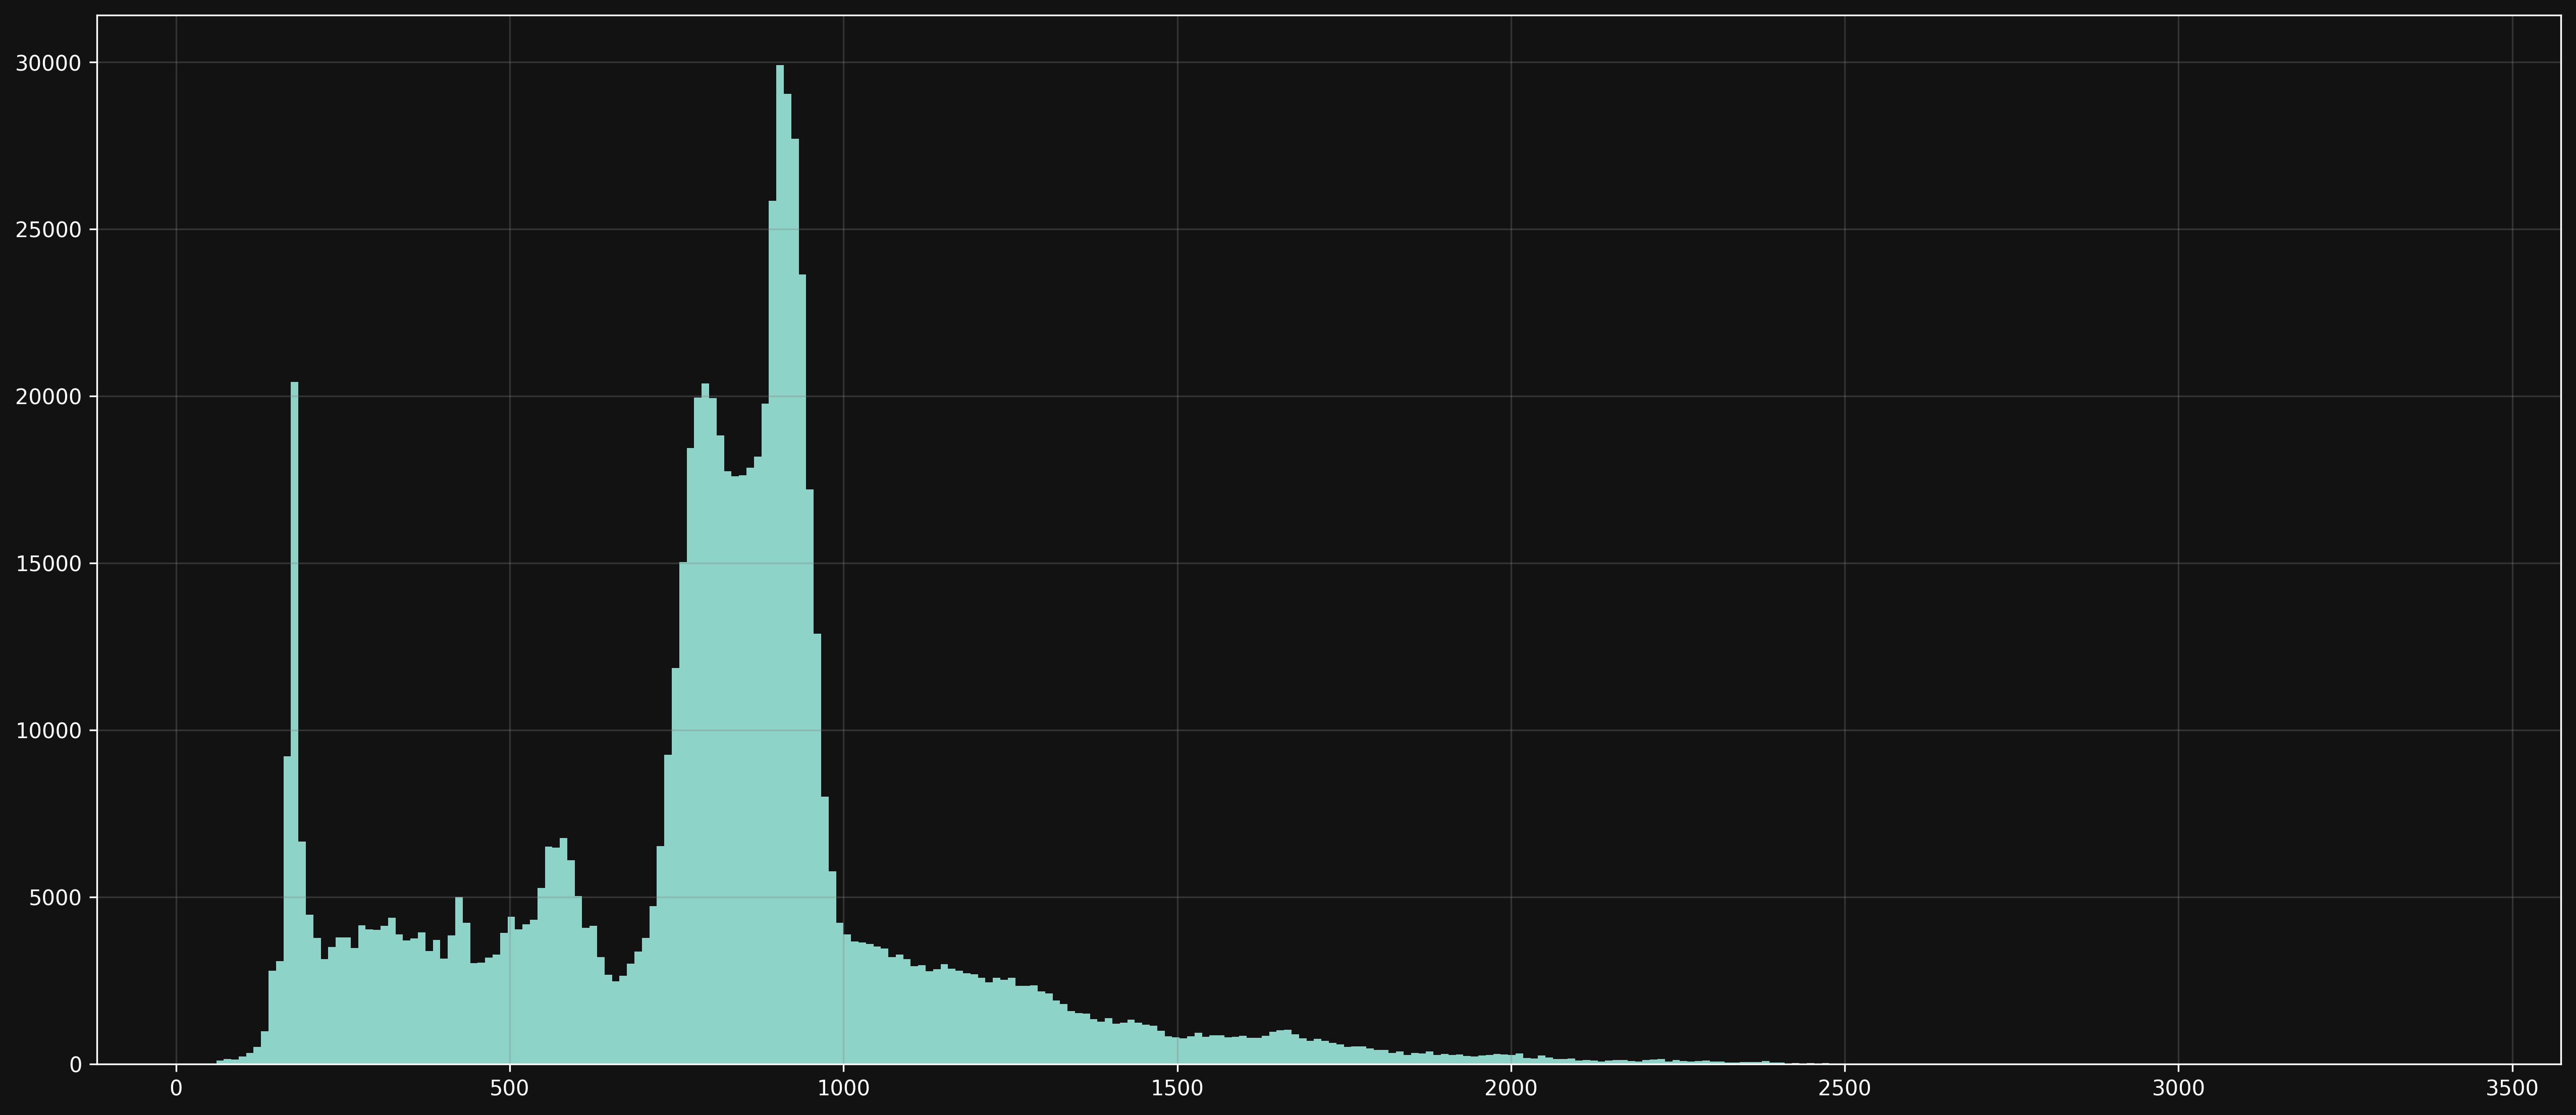

In [ ]:
pd.Series(np.clip(inverse_y(cbr.predict(X_test)), 20, 5000), name='Premium Amount', index = X_test.index).to_csv('1classify+3reg_without_fold.csv', header=True)

In [151]:
inverse_y(y).min()

20.0

<Axes: ylabel='Density'>

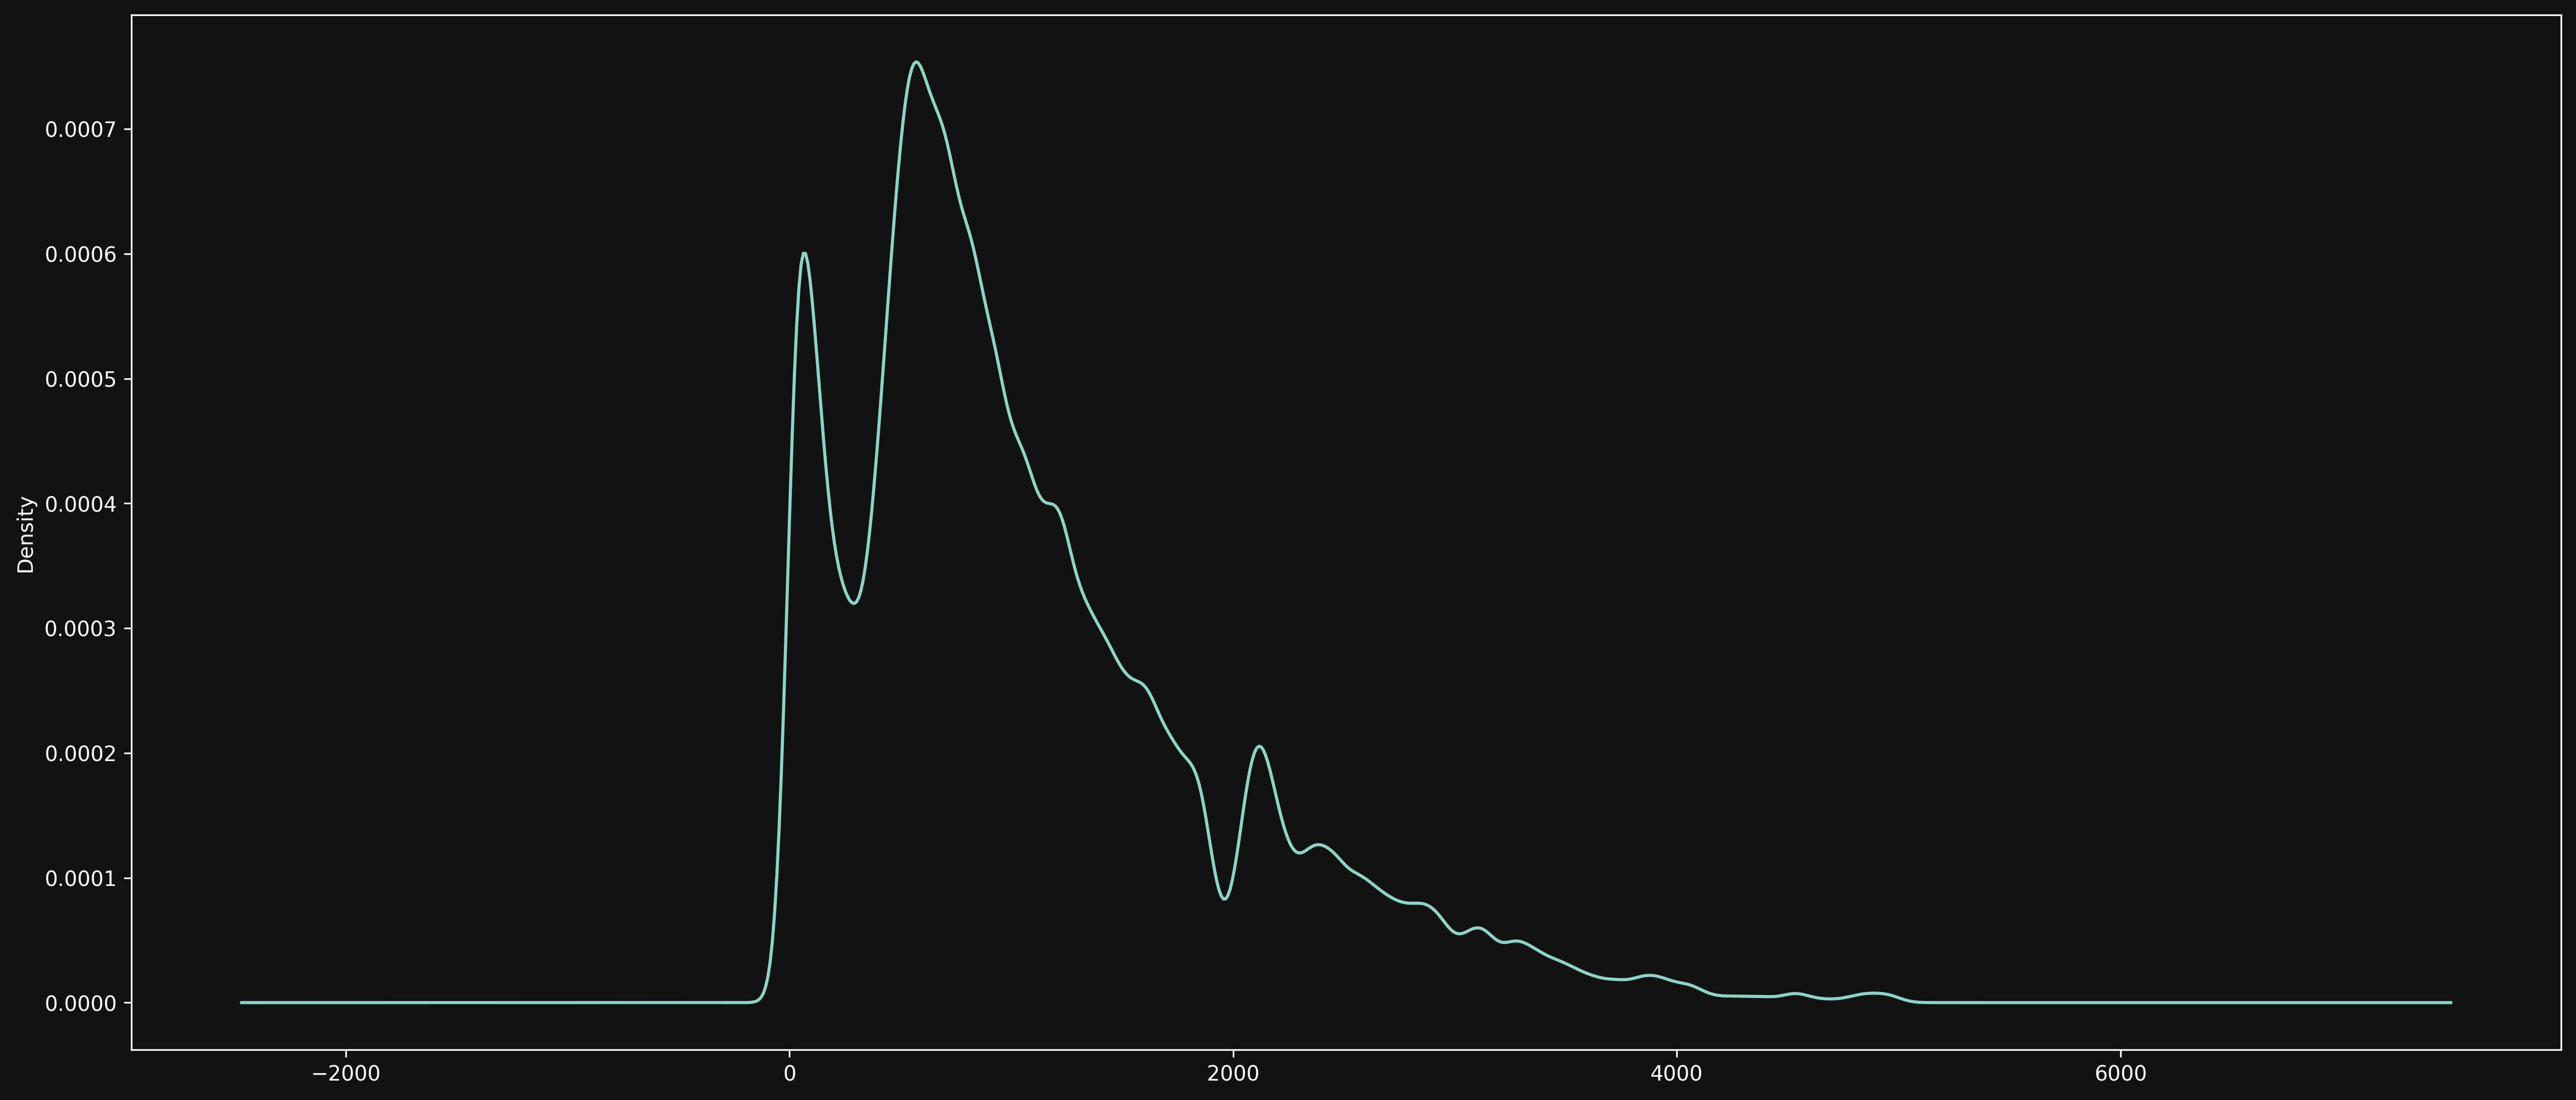

In [187]:
pd.Series(inverse_y(y)).plot.kde()

<Axes: >

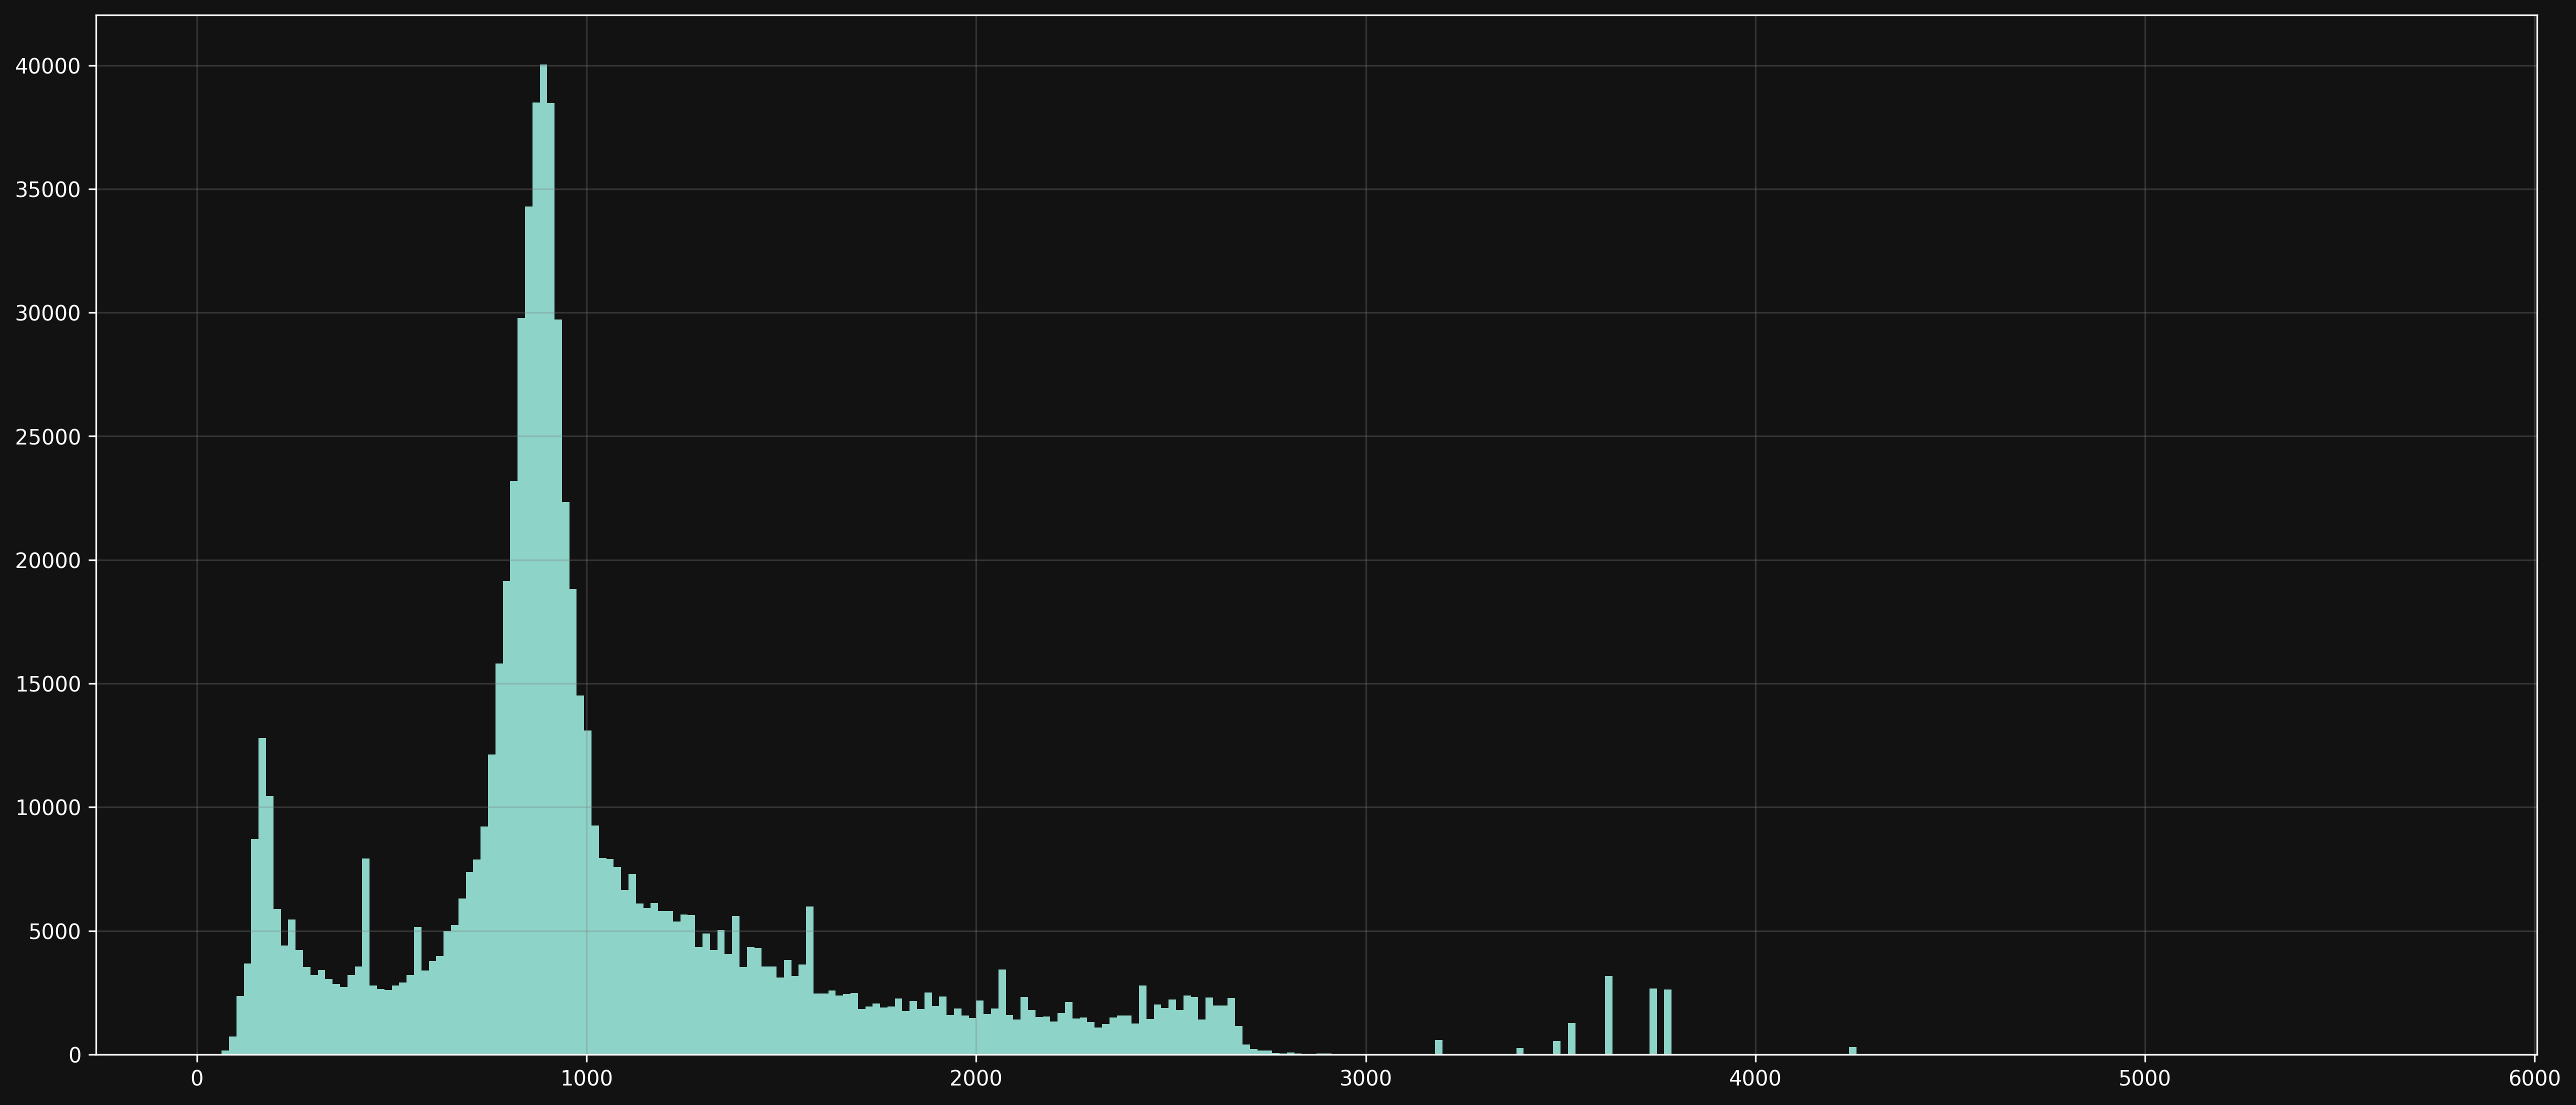

In [126]:
pd.Series(inverse_y(cbr.predict(X_test)), name='Premium Amount', index = X_test.index).hist(bins=300)#.to_csv('3reg+1reg_without_fold.csv', header=True)

array([[<Axes: title={'center': 'Premium Amount'}>]], dtype=object)

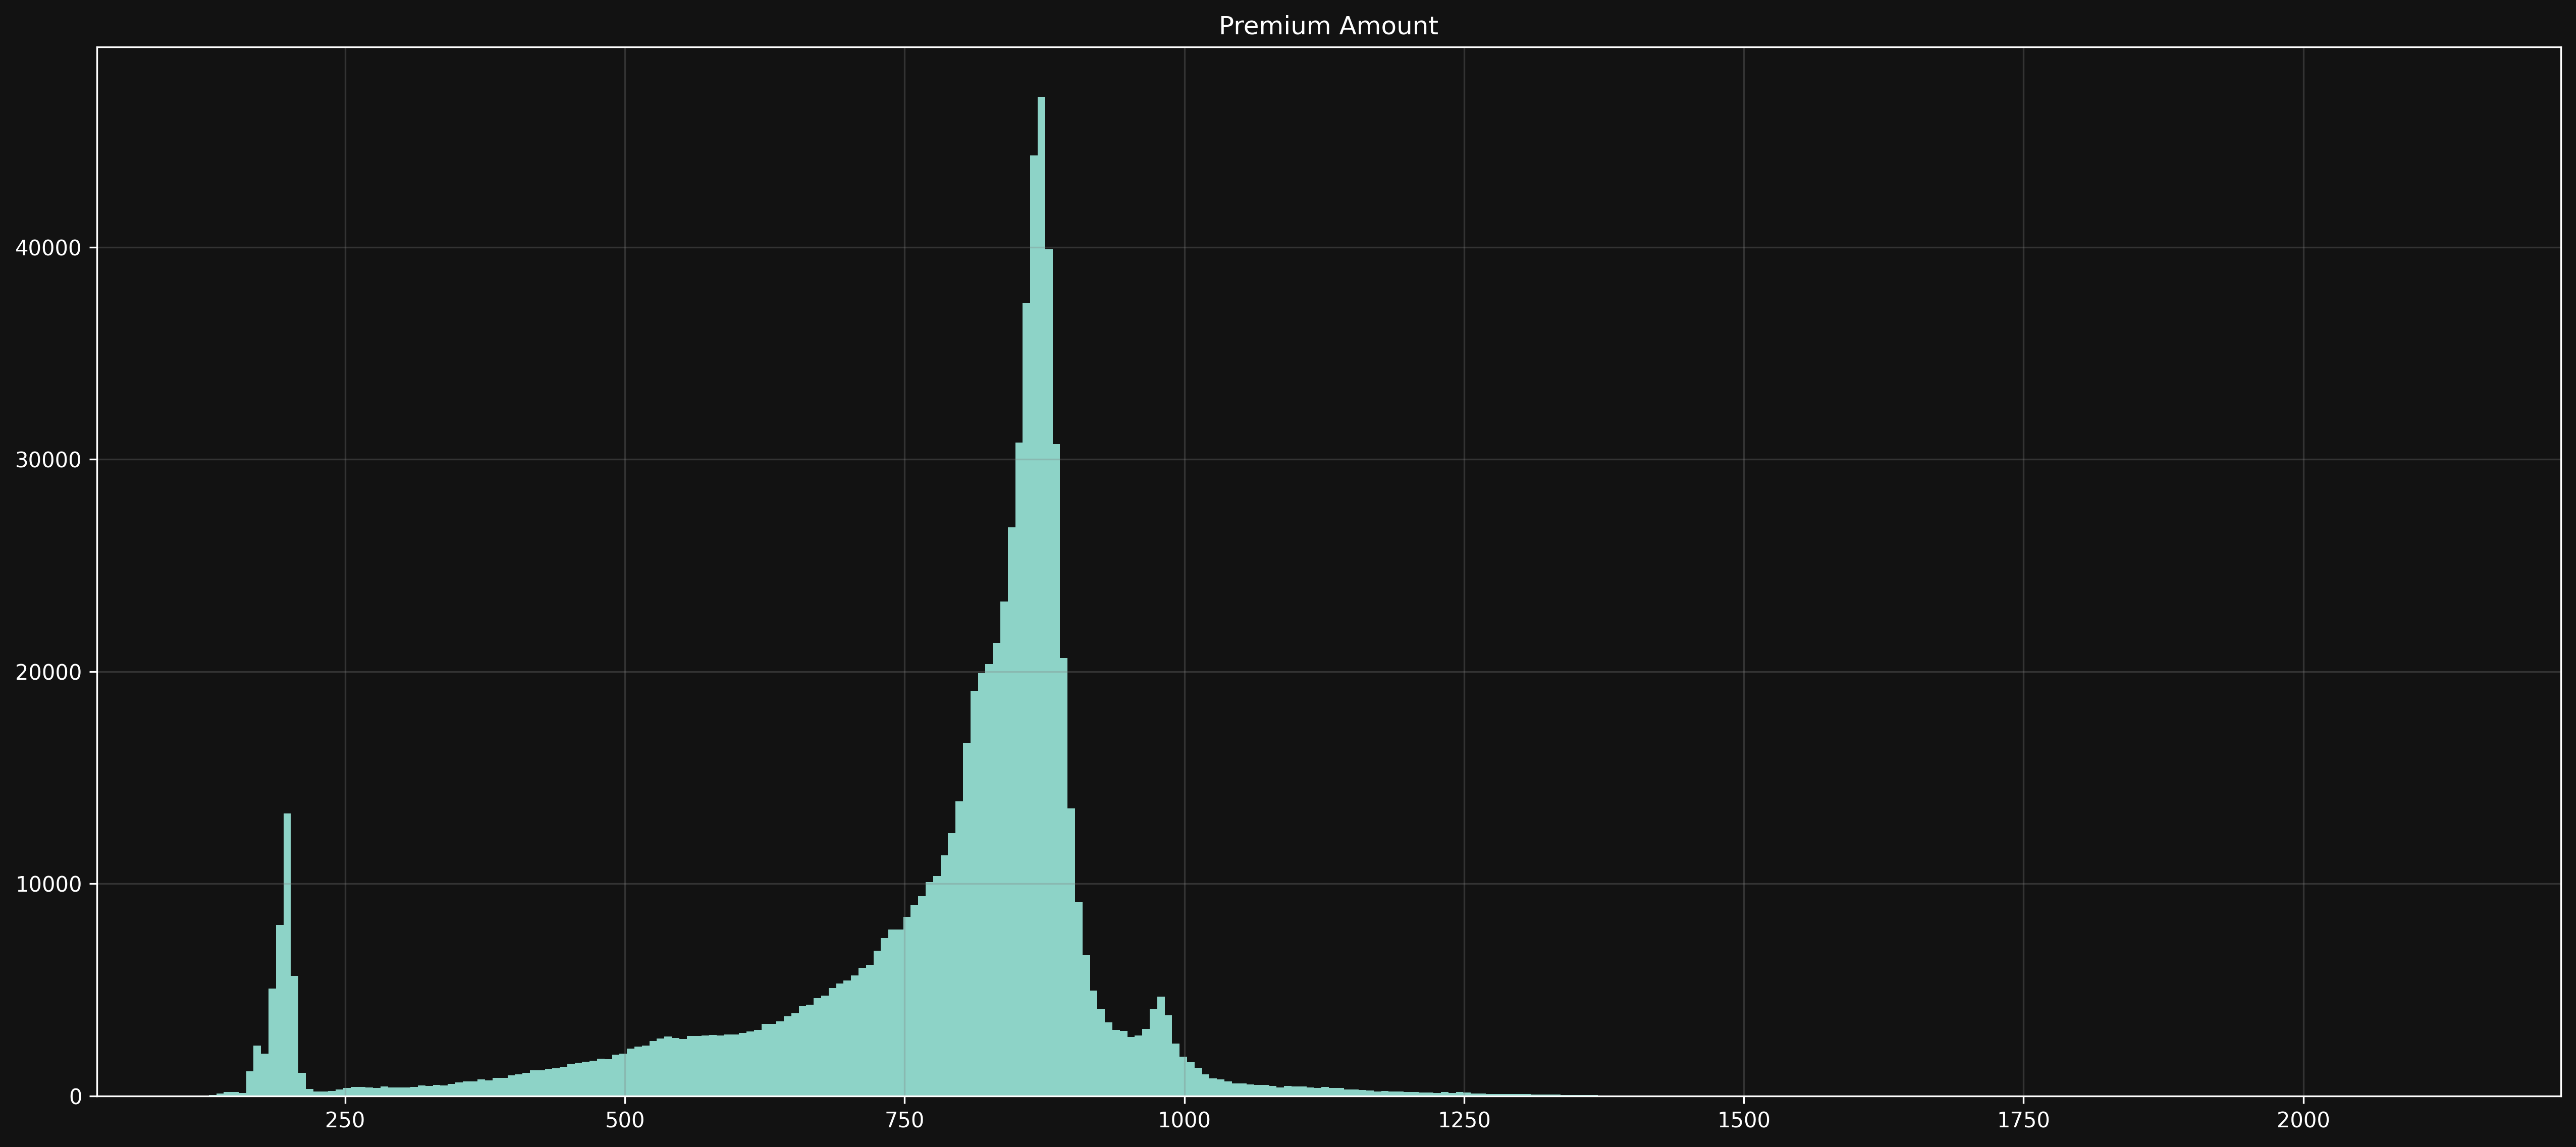

In [104]:
pd.read_csv('./blended_best_submission.csv', index_col=0).hist(bins=300)

<Axes: >

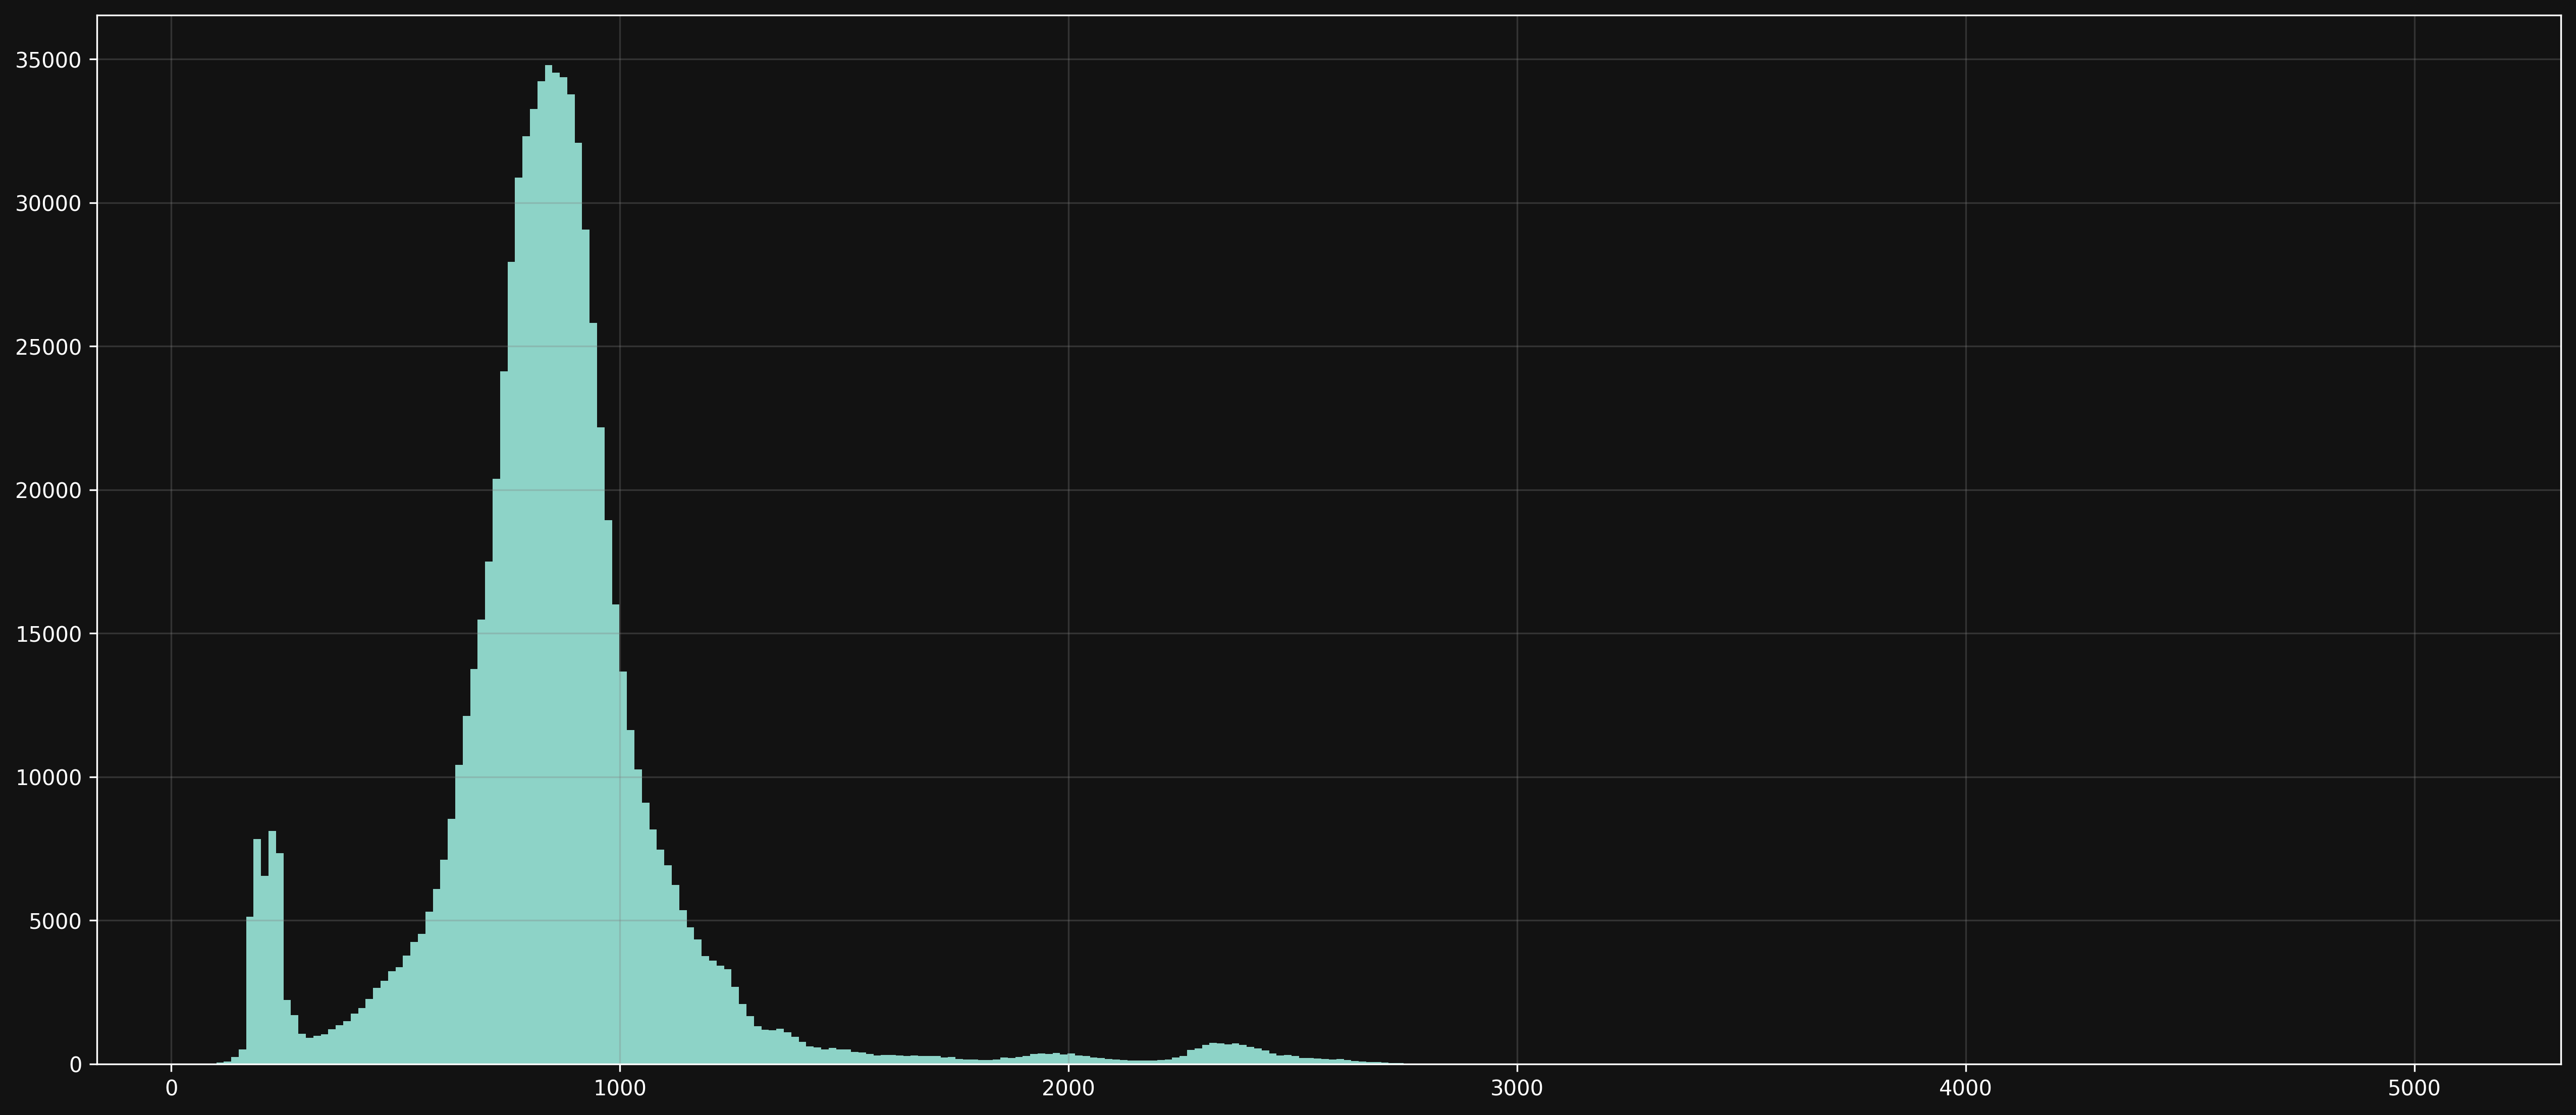

In [49]:
pd.Series(inverse_y(cbr.predict(X_test)), name='Premium Amount', index = X_test.index).hist(bins=300)#.to_csv('3reg+1reg_without_fold.csv', header=True)

In [ ]:
# RMSLE_WITH_INVERSE:   (0.13000275959065588, 0.8709315569916333, 1.0226638755292026)
# MSE:                  (0.1300023166906178, 0.8709320003673153, 1.0226641358391153)

In [56]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models= []
oof_preds = np.zeros(X.shape[0])
test_preds = np.zeros((X_test.shape[0], 5))
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, _X_val = X.values[train_idx], X.values[val_idx]
    y_train, _y_val = y[train_idx], y[val_idx]

    model = LGBMRegressor(
        num_leaves=31,
        min_child_samples=7,
        min_child_weight=0.003,
        
        n_estimators=300,
        max_depth=10,
        learning_rate=0.1,
        
        n_jobs=-1,
        random_state=42,
        verbosity=-1,
        gpu_id=0,
        device_type='gpu',
        verbose=50,
    )
    model.fit(X_train, y_train, eval_set=[(_X_val, _y_val)])
    models.append(model)
    pred = model.predict(_X_val)
    oof_preds[val_idx] = pred
    test_preds[:, i] = model.predict(X_test)
    print(evaluate_model(model, _X_val, _y_val))
del _X_val, _y_val

(0.2939702190711362, 0.7067880078533557, 0.9212669426792536)
(0.29350549767876455, 0.705700293638754, 0.9205577760184674)
(0.294121264646967, 0.7049115594793453, 0.9200431961321452)
(0.29806350633416456, 0.7016644787573669, 0.9179217223392689)
(0.2917071213514507, 0.7095467197868094, 0.9230631212531016)


In [57]:
alert()

In [59]:
pd.Series(np.clip(inverse_y(test_preds.mean(1)),20, 5000), index=X_test.index, name='Premium Amount').to_csv('1classify+3reg_with_fold.csv', header=True)

<Axes: >

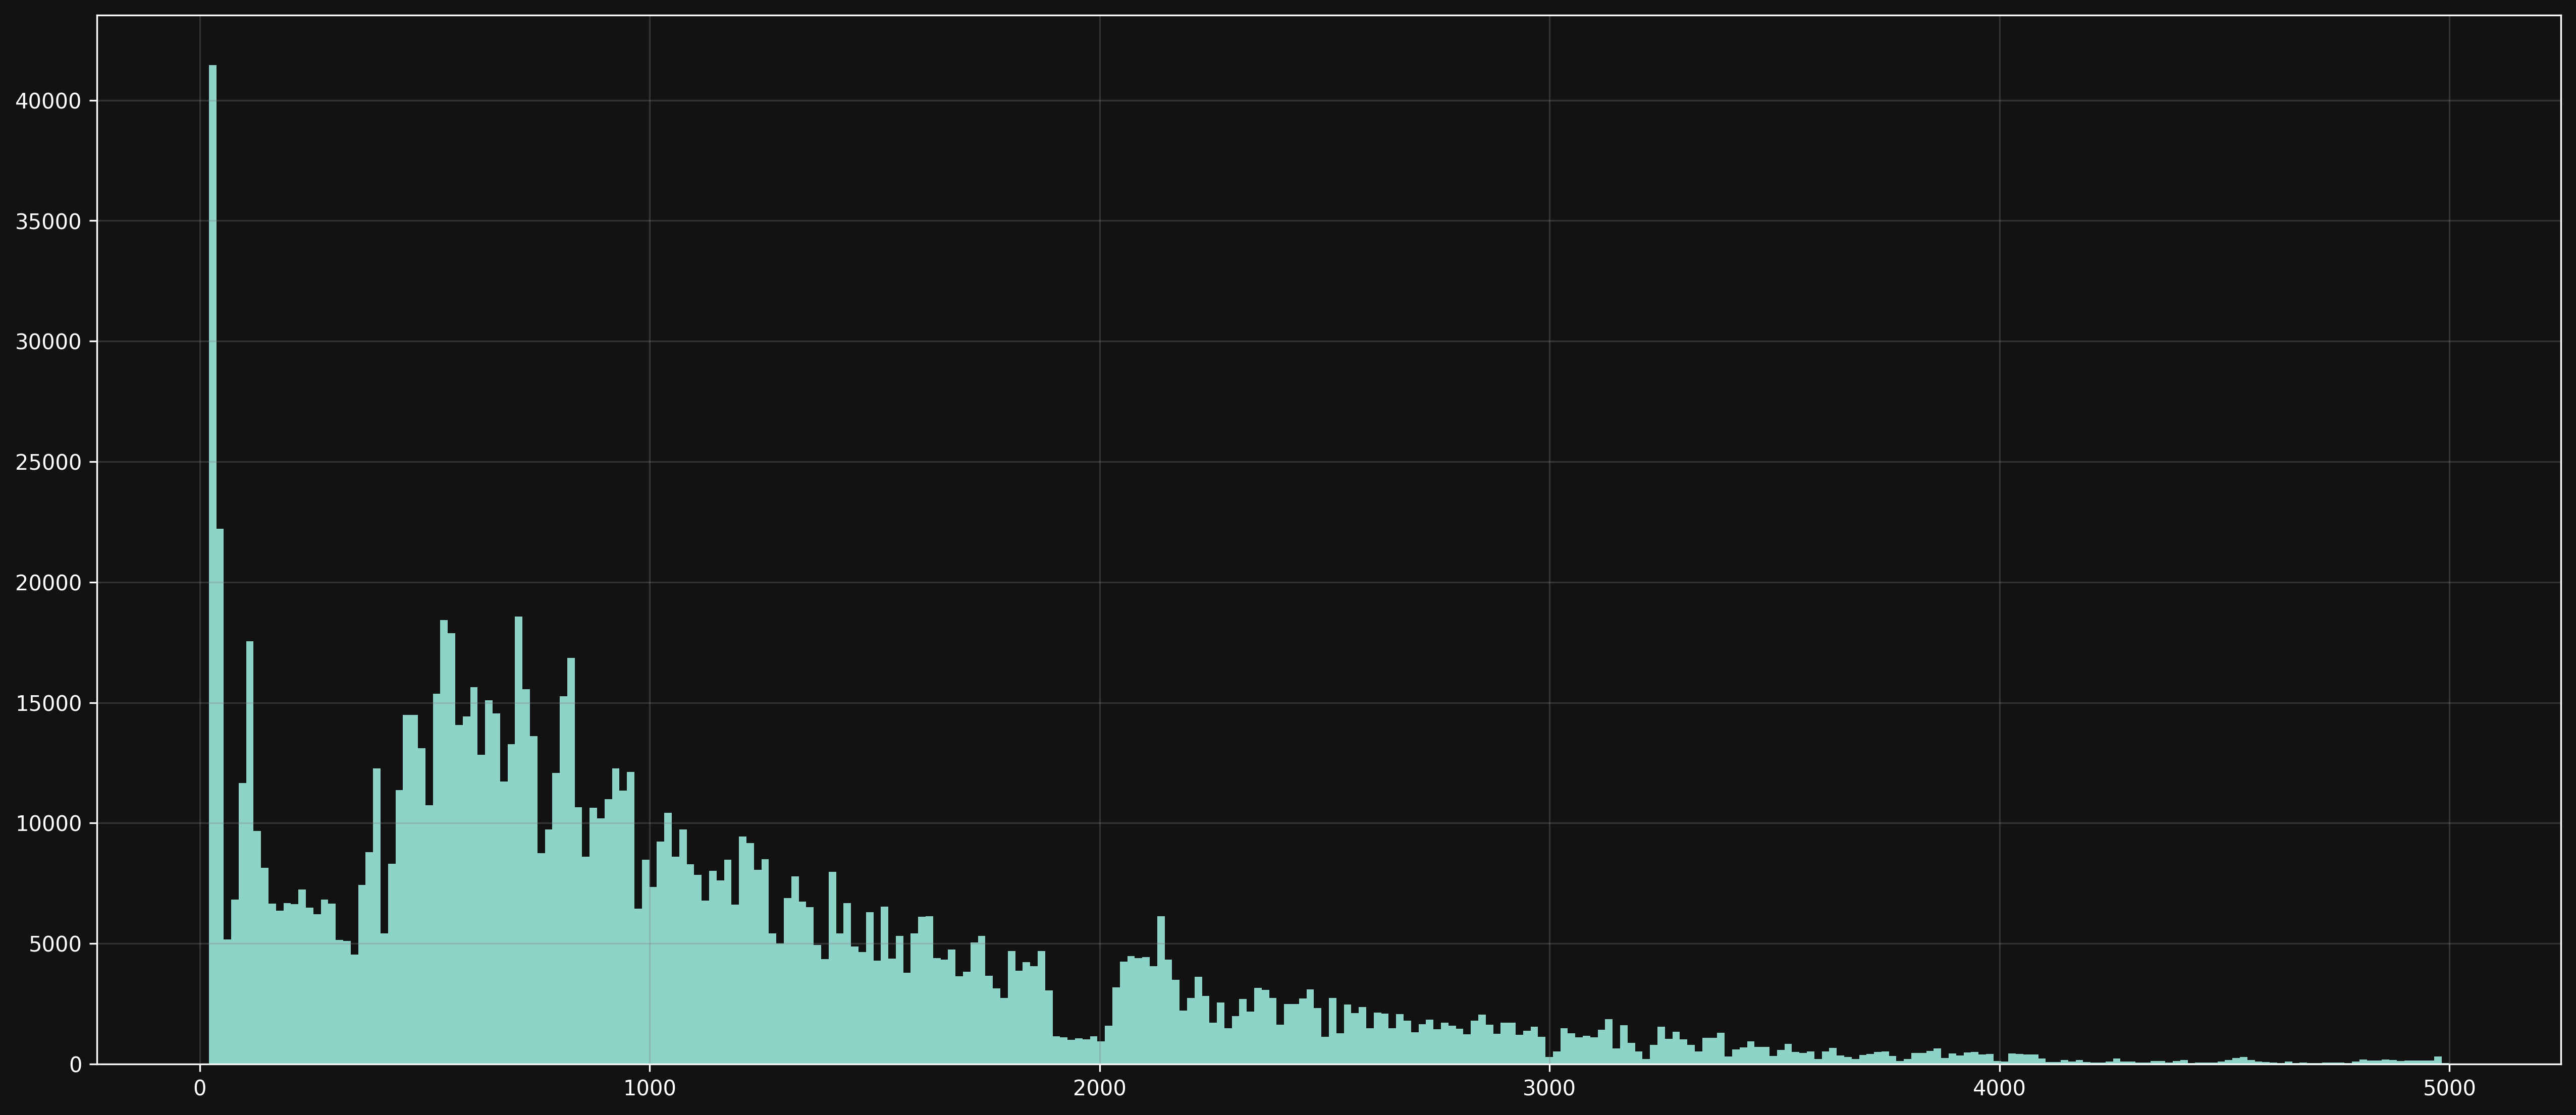

In [187]:
pd.Series(inverse_y(y)).hist(bins=300)

In [26]:
def lgbm_objective(trial: optuna.Trial):
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42) 
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 10),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 400, 600),
        'max_depth': trial.suggest_int('max_depth', 20, 40),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        # 'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 5),
        # "categorical_feature": categorical_columns.values,
        "seed": 42,
        'device_type': 'gpu',
        # "eval_metric": rmlse_with_inverse,
        "verbose": -1
    }

    models = []
    overall_score = 0 
    
    for i, (train_idx, val_idx) in enumerate(kf.split(X)):
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx] 
        
        model = LGBMRegressor(**params) 
        model.fit(
            X_train,
            y_train,
            eval_set=(X_val, y_val),
            eval_metric=rmlse_with_inverse,
        ) 
        
        models.append(model) 

        y_pred = model.predict(X_val)
        y_pred = inverse_y(y_pred)
        y_pred = np.maximum(0, y_pred)
        y_val = inverse_y(y_val)
        score = lgb_rmsle(y_val, y_pred)[1]
        
        overall_score += score 
        
        print(f'=== Fold {i + 1} RMSLE Score: {score:} ===') 
        
    avg_score = overall_score / kf.n_splits 
    print(f"Overall RMSLE: {avg_score}") 

    return avg_score 

In [27]:
study = optuna.create_study(direction='minimize')
study.optimize(lgbm_objective, n_trials=100, )

[I 2024-12-26 18:39:25,717] A new study created in memory with name: no-name-4622a3b8-761c-4754-b981-116b2ff17744


=== Fold 1 RMSLE Score: 1.0334373044678296 ===
=== Fold 2 RMSLE Score: 1.032322917350245 ===
=== Fold 3 RMSLE Score: 1.0339506781037344 ===
=== Fold 4 RMSLE Score: 1.0311663775956317 ===


[I 2024-12-26 18:41:33,034] Trial 0 finished with value: 1.0328446281388328 and parameters: {'num_leaves': 25, 'min_child_samples': 9, 'min_child_weight': 0.01742445783616352, 'n_estimators': 443, 'max_depth': 31, 'learning_rate': 0.010049713714955272, 'feature_fraction': 0.9838569485796165, 'bagging_fraction': 0.8706816115884023, 'lambda_l1': 0.8518384167007444, 'lambda_l2': 0.01589194514962719, 'reg_alpha': 0.013900066021231325, 'reg_lambda': 0.7506999786723523, 'subsample_freq': 2}. Best is trial 0 with value: 1.0328446281388328.


=== Fold 5 RMSLE Score: 1.0333458631767236 ===
Overall RMSLE: 1.0328446281388328


[W 2024-12-26 18:41:47,017] Trial 1 failed with parameters: {'num_leaves': 27, 'min_child_samples': 5, 'min_child_weight': 0.0012149948329592962, 'n_estimators': 568, 'max_depth': 35, 'learning_rate': 0.018762047356438882, 'feature_fraction': 0.7804745666844903, 'bagging_fraction': 0.630057432088643, 'lambda_l1': 0.5921015543315116, 'lambda_l2': 3.150467826184469, 'reg_alpha': 4.8306304997821465, 'reg_lambda': 0.013399130272965418, 'subsample_freq': 2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\gus47\Desktop\workspace\kaggle\regression-with-an-insurance-dataset\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\gus47\AppData\Local\Temp\ipykernel_6764\3464246506.py", line 35, in lgbm_objective
    model.fit(
  File "c:\Users\gus47\Desktop\workspace\kaggle\regression-with-an-insurance-dataset\.venv\Lib\site-packages\li

KeyboardInterrupt: 

In [28]:
study.best_params

{'n_estimators': 904,
 'learning_rate': 0.22397849703318146,
 'max_depth': 6,
 'reg_lambda': 1.0772060124044087,
 'subsample': 0.7276099887947944,
 'subsample_freq': 1,
 'min_child_samples': 12}

In [46]:
study.best_params, study.best_value

({'num_leaves': 40,
  'min_child_samples': 10,
  'min_child_weight': 0.06465924287223622,
  'n_estimators': 459,
  'max_depth': 30,
  'learning_rate': 0.046995524079346984,
  'feature_fraction': 0.9677961468326596,
  'bagging_fraction': 0.6627290192138932,
  'lambda_l1': 8.692580281983838,
  'lambda_l2': 3.4256066884728638,
  'reg_alpha': 0.08455745202708774,
  'reg_lambda': 0.007744807329888691,
  'boosting_type': 'gbdt'},
 1.0462689704206725)

### XGBoost only

In [68]:
# early_stopping_rounds
early_stop = xgb.callback.EarlyStopping(
    rounds=10, data_name='validation_0', save_best=True, metric_name='lse',
)
xgbr = XGBRegressor(
    n_estimators=500,
    disable_default_eval_metric=True,
    max_depth=15,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    objective='reg:squaredlogerror',
    # objective=squared_log,
    # objective=xgb_sle_objective,
    eval_metric=xgb_rmsle_evaluation,
    # gpu_id=0,
    # num_parallel_tree=1,
    # callbacks=[early_stop]
)
xgbr.fit(X_train, inverse_y(y_train), eval_set=[(X_train, inverse_y(y_train)), (X_val, inverse_y(y_val))], verbose=10)

[0]	validation_0-xgb_rmsle_evaluation:5.98773	validation_1-xgb_rmsle_evaluation:5.98806
[10]	validation_0-xgb_rmsle_evaluation:5.19099	validation_1-xgb_rmsle_evaluation:5.19132
[20]	validation_0-xgb_rmsle_evaluation:4.41929	validation_1-xgb_rmsle_evaluation:4.41963
[30]	validation_0-xgb_rmsle_evaluation:3.68106	validation_1-xgb_rmsle_evaluation:3.68142
[40]	validation_0-xgb_rmsle_evaluation:2.98937	validation_1-xgb_rmsle_evaluation:2.98976
[50]	validation_0-xgb_rmsle_evaluation:2.36515	validation_1-xgb_rmsle_evaluation:2.36560
[60]	validation_0-xgb_rmsle_evaluation:1.84242	validation_1-xgb_rmsle_evaluation:1.84295
[70]	validation_0-xgb_rmsle_evaluation:1.46057	validation_1-xgb_rmsle_evaluation:1.46123
[80]	validation_0-xgb_rmsle_evaluation:1.23952	validation_1-xgb_rmsle_evaluation:1.24025
[90]	validation_0-xgb_rmsle_evaluation:1.14185	validation_1-xgb_rmsle_evaluation:1.14248
[100]	validation_0-xgb_rmsle_evaluation:1.10469	validation_1-xgb_rmsle_evaluation:1.10522
[110]	validation_0-xg

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None,
             disable_default_eval_metric=True, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function xgb_rmsle_evaluation at 0x00000271B7C5CB80>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [69]:
evaluate_model_no_inverse(xgbr, X_val, inverse_y(y_val))

(-0.18375731802889073, 884604.7812322278, 1.0773850542888421)

In [323]:
evaluate_model_no_inverse(xgbr, X_val, inverse_y(y_val))

(-0.21583451785926044, 908575.6103086942, 1.0847206771631082)

### Catboost only

In [44]:
# catboost with rmlse
cbr = cat.CatBoostRegressor(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.1,
    random_state=42,
    verbose=10,
    # eval_metric=RmsleMetric(use_inverse=True),
    # loss_function=SleObjective(use_inverse=True),
)
cbr.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=30)
evaluate_model(cbr, X_val, y_val)

0:	learn: 0.9916882	test: 0.9925914	best: 0.9925914 (0)	total: 1.47s	remaining: 12m 11s
10:	learn: 0.9576118	test: 0.9623710	best: 0.9623710 (10)	total: 16.4s	remaining: 12m 9s
20:	learn: 0.9482050	test: 0.9582013	best: 0.9582013 (20)	total: 31.5s	remaining: 11m 59s
30:	learn: 0.9412060	test: 0.9577900	best: 0.9577776 (29)	total: 46.5s	remaining: 11m 43s
40:	learn: 0.9335835	test: 0.9579525	best: 0.9577407 (32)	total: 1m 1s	remaining: 11m 32s
50:	learn: 0.9257297	test: 0.9581158	best: 0.9577407 (32)	total: 1m 17s	remaining: 11m 18s
60:	learn: 0.9139443	test: 0.9586108	best: 0.9577407 (32)	total: 1m 32s	remaining: 11m 7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.9577406811
bestIteration = 32

Shrink model to first 33 iterations.


(0.08371681654638519, 0.9172672079224402, 1.0495154487534142)

### LGBM only

In [145]:
lgbr = LGBMRegressor(
    num_leaves=31,
    min_child_samples=20,
    min_child_weight=0.001,
    
    n_estimators=100,
    max_depth=20,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=2024,
    # verbosity=1,
    # objective='squaredlogerror',
    objective=lgb_lse_objective_with_inverse,

)

lgbr.fit(X_train, (y_train), eval_set=[(X_val, (y_val))], eval_metric=lgb_rmsle_with_inverse)
evaluate_model(lgbr, X_val, (y_val))

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1114
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 19
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=20) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1048576) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Using self-defined objective function


(-0.3338316591563564, 1.335264101673698, 1.2662646659398453)

In [136]:
lgbr = LGBMRegressor(
    num_leaves=31,
    min_child_samples=20,
    min_child_weight=0.001,
    
    n_estimators=100,
    max_depth=20,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=2024,
    # verbosity=1,
    # objective='squaredlogerror',
    objective=lgb_lse_objective,

)

lgbr.fit(X_train, inverse_y(y_train), eval_set=[(X_val, inverse_y(y_val))], eval_metric=lgb_rmsle)
evaluate_model_no_inverse(lgbr, X_val, inverse_y(y_val))

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1114
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 19
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=20) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1048576) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Using self-defined objective function


KeyboardInterrupt: 

In [107]:
evaluate_model(lgbr, X_val, y_val)

(-2.213027960884517e-08, 1.0010739526665722, 1.096412510893123)

In [ ]:
# SVM
from sklearn.svm import SVR
svr = SVR(
    C=1,
    epsilon=2.25,
)
svr.fit(X_train, y_train)

In [218]:
import pickle
svr = pd.read_pickle('svr.pkl')

In [75]:
# save svr model because it takes too long to train
import pickle
with open('svr.pkl', 'wb') as f:
    pickle.dump(svr, f)

In [220]:
evaluate_model(svr, X_val[:, 1:], y_val)

(-0.41186115869286777, 1.4133773994706387, 1.3027766711381177)

# Submission

In [52]:
def make_ans(model):
    ans=inverse_y(model.predict(test.values))
    return pd.Series(ans, index = test.index).rename('Premium Amount')

In [54]:
ans = make_ans(lgbm)
ans.to_csv('submission.csv', header=True)